In [ ]:
%pip install scikit-image

# White Blood Cell Segmentation  

This notebook focuses on segmenting nine different classes of blood cells from microscopy images. The segmentation process involves:  

- Converting images to appropriate color spaces for better feature extraction.  
- Applying thresholding and morphological operations to refine cell boundaries.  
- Identifying and isolating individual cells while filtering out noise.  

The goal is to create accurate segmentation masks for each class, which can be used for further analysis or downstream tasks.  


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from skimage import exposure
import glob
import shutil
from pathlib import Path
from ultralytics import YOLO

## Basophil

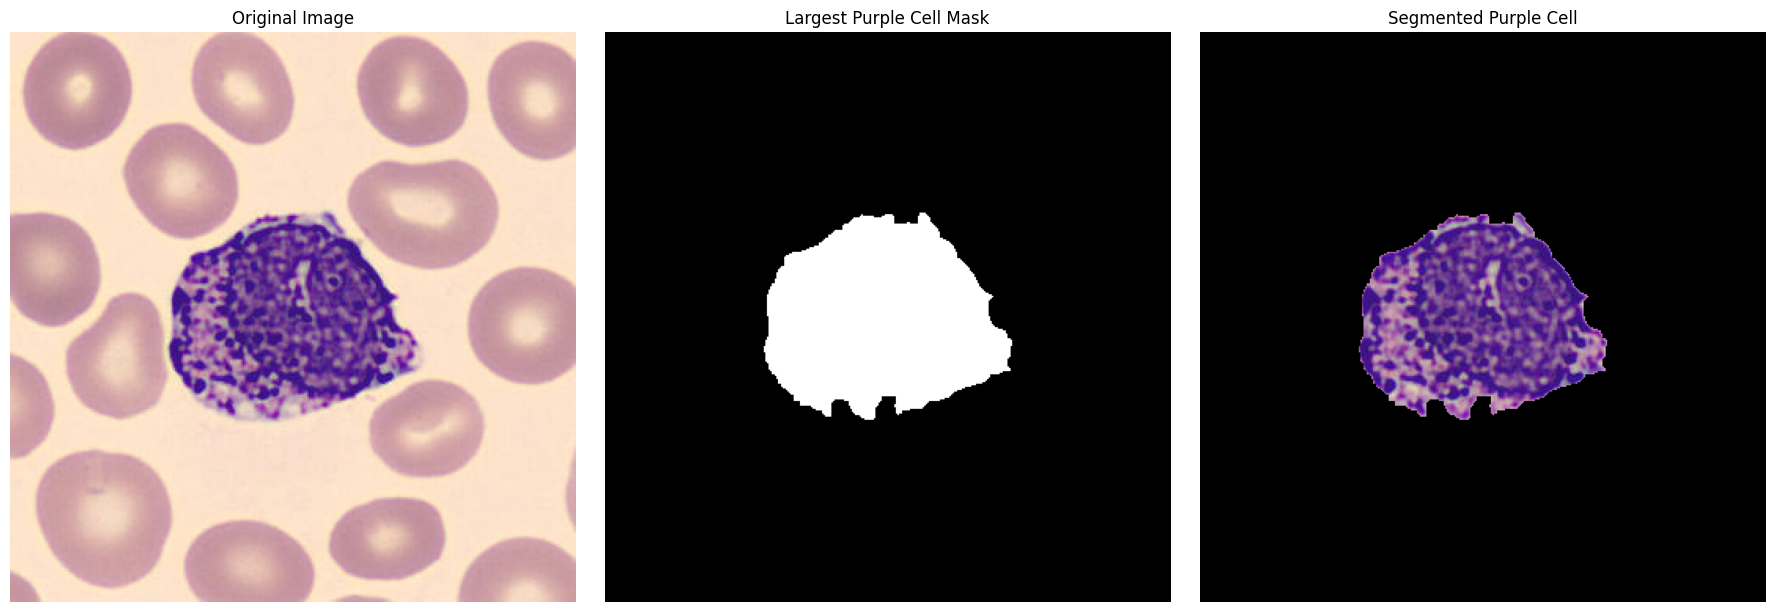

Randomly selected image: BA_845828.jpg


In [38]:
# Folder containing images
image_folder = "/Users/afnanag/projects/DH307/yolov11/segmentation/data/basophil/images"

# Get list of all images in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith((".jpg", ".png", ".jpeg"))]

# Randomly select an image
random_image = random.choice(image_files)
image_path = os.path.join(image_folder, random_image)

# Load the randomly selected image
image = cv2.imread(image_path)

# Convert image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define range for purple color in HSV
lower_purple = np.array([120, 50, 50])
upper_purple = np.array([160, 255, 255])

# Threshold the image to get only purple colors
mask = cv2.inRange(hsv, lower_purple, upper_purple)

# Perform morphological operations to clean up noise
kernel = np.ones((5, 5), np.uint8)
mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Find contours in the mask (fixed the typo here)
contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# If contours are found, keep only the largest one
if contours:
    largest_contour = max(contours, key=cv2.contourArea)  # Get the largest contour
    largest_mask = np.zeros_like(mask)  # Create an empty mask
    cv2.drawContours(largest_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)  # Fill the largest contour
    mask_cleaned = largest_mask  # Update the mask to keep only the largest detected object

# Convert image to RGB for display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create a segmented image by applying the mask
segmented = np.zeros_like(image)
segmented[mask_cleaned == 255] = image[mask_cleaned == 255]
segmented_rgb = cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB)

# Display the original image, segmentation mask, and segmented image
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image_rgb)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(mask_cleaned, cmap='gray')
axes[1].set_title("Largest Purple Cell Mask")
axes[1].axis("off")

axes[2].imshow(segmented_rgb)
axes[2].set_title("Segmented Purple Cell")
axes[2].axis("off")

plt.tight_layout()
plt.show()

# Print the randomly selected image name
print(f"Randomly selected image: {random_image}")

In [ ]:
def segment_purple_cell(image_path):
    """
    Segment the largest purple cell in an image and save it with transparent background
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_path}")
        return None
        
    # Convert image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define range for purple color in HSV
    lower_purple = np.array([120, 50, 50])
    upper_purple = np.array([160, 255, 255])
    
    # Threshold the image to get only purple colors
    mask = cv2.inRange(hsv, lower_purple, upper_purple)
    
    # Perform morphological operations to clean up noise
    kernel = np.ones((5, 5), np.uint8)
    mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Find contours in the mask
    contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # If contours are found, keep only the largest one
    if not contours:
        print(f"No purple cells found in {os.path.basename(image_path)}")
        return None
        
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Create an empty mask and fill the largest contour
    largest_mask = np.zeros_like(mask)
    cv2.drawContours(largest_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    
    # Get the bounding rectangle of the contour to crop the image closely
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Create a transparent 4-channel image (RGBA) with the size of the bounding rectangle
    segmented_cropped = np.zeros((h, w, 4), dtype=np.uint8)
    
    # Create a mask for the cropped region
    cropped_mask = largest_mask[y:y+h, x:x+w]
    
    # Copy RGB values from original image to the cropped region where mask is active
    segmented_cropped[:, :, 0:3][cropped_mask == 255] = image[y:y+h, x:x+w][cropped_mask == 255]
    
    # Set alpha channel - transparent (0) where inactive, opaque (255) where active
    segmented_cropped[:, :, 3] = cropped_mask
    
    return segmented_cropped, os.path.basename(image_path)

# Main execution
if __name__ == "__main__":
    # Folder containing images
    image_folder = "/Users/afnanag/projects/DH307/yolov11/segmentation/data/basophil/images"
    
    # Create output directory
    output_dir = os.path.join(os.path.dirname(image_folder), "segmented_cells")
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all image files in the folder
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
    
    # Count for progress tracking
    total_images = len(image_files)
    successful_segments = 0
    failed_segments = 0
    
    print(f"Found {total_images} images to process...")
    
    # Process each image
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(image_folder, image_file)
        print(f"[{i+1}/{total_images}] Processing {image_file}...")
        
        # Segment the image
        result = segment_purple_cell(image_path)
        
        if result is not None:
            segmented_img, original_filename = result
            
            # Save the segmented image with transparent background
            output_filename = f"segmented_{os.path.splitext(original_filename)[0]}.png"
            output_path = os.path.join(output_dir, output_filename)
            
            # Save to PNG to preserve transparency
            cv2.imwrite(output_path, segmented_img)
            print(f"  ✓ Saved {output_filename}")
            successful_segments += 1
        else:
            print(f"  ✗ Failed to segment {image_file}")
            failed_segments += 1
    
    print(f"\nSegmentation complete!")
    print(f"Successfully segmented: {successful_segments}/{total_images} images")
    print(f"Failed to segment: {failed_segments}/{total_images} images")
    print(f"Segmented images saved to: {output_dir}")

Found 1218 images to process...
[1/1218] Processing BA_689200.jpg...
  ✓ Saved segmented_BA_689200.png
[2/1218] Processing BA_883452.jpg...
  ✓ Saved segmented_BA_883452.png
[3/1218] Processing BA_382161.jpg...
  ✓ Saved segmented_BA_382161.png
[4/1218] Processing BA_175579.jpg...
  ✓ Saved segmented_BA_175579.png
[5/1218] Processing BA_775722.jpg...
  ✓ Saved segmented_BA_775722.png
[6/1218] Processing BA_209608.jpg...
  ✓ Saved segmented_BA_209608.png
[7/1218] Processing BA_977935.jpg...
  ✓ Saved segmented_BA_977935.png
[8/1218] Processing BA_95396.jpg...
  ✓ Saved segmented_BA_95396.png
[9/1218] Processing BA_693714.jpg...
  ✓ Saved segmented_BA_693714.png
[10/1218] Processing BA_878384.jpg...
  ✓ Saved segmented_BA_878384.png
[11/1218] Processing BA_691117.jpg...
  ✓ Saved segmented_BA_691117.png
[12/1218] Processing BA_240977.jpg...
  ✓ Saved segmented_BA_240977.png
[13/1218] Processing BA_762060.jpg...
  ✓ Saved segmented_BA_762060.png
[14/1218] Processing BA_347981.jpg...
  ✓ S

## Eosinophil, Erythroblast, Lymphocyte

Selected random image: EO_380528.jpg


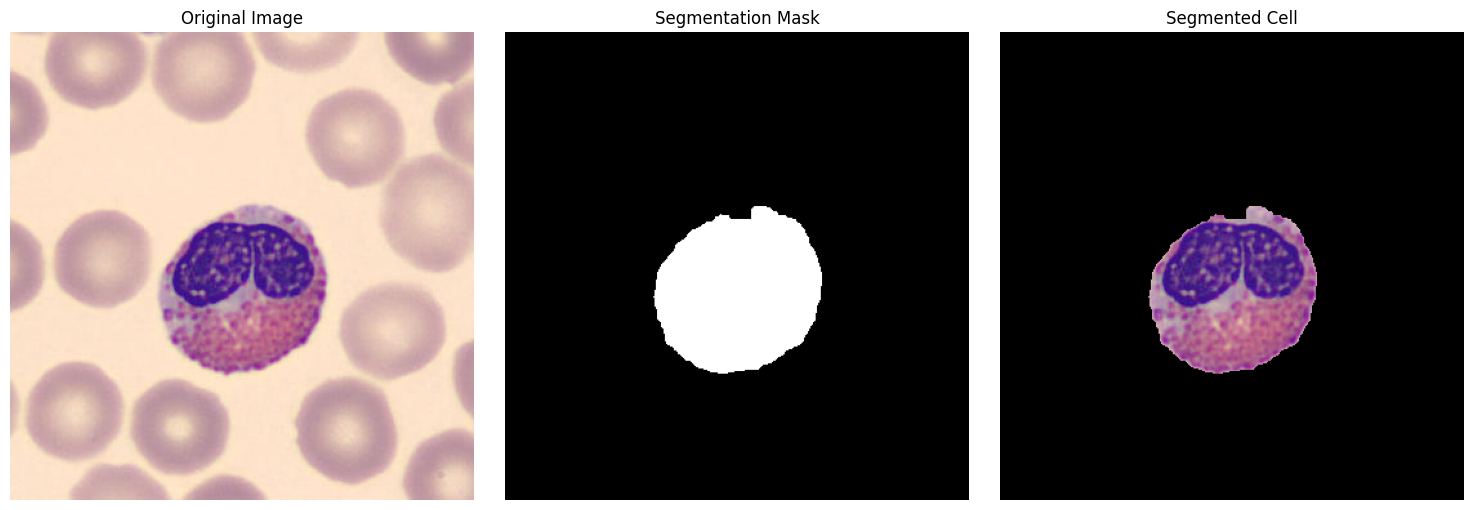

In [5]:
def segment_white_blood_cell(image_path):
    """
    Segment the central white blood cell from a microscopy image.
    
    Args:
        image_path (str): Path to the input image
    
    Returns:
        tuple: Original image, segmentation mask, and segmented cell
    """
    # Read the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    
    # Split the LAB image to different channels
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    # Merge the CLAHE enhanced L-channel back with the A and B channels
    enhanced_lab = cv2.merge((cl, a, b))
    
    # Convert back to RGB
    enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    
    # Convert to grayscale
    gray = cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Otsu's thresholding
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Perform morphological operations to clean up the mask
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Find contours
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a mask
    mask = np.zeros_like(opening)
    
    # If contours exist
    if contours:
        # Find the central contour (assuming the WBC is in the center)
        center_x, center_y = img.shape[1] // 2, img.shape[0] // 2
        closest_contour = None
        min_distance = float('inf')
        
        for contour in contours:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                distance = np.sqrt((cx - center_x)**2 + (cy - center_y)**2)
                area = cv2.contourArea(contour)
                
                # Filter by area to avoid small noise contours
                if area > 500 and distance < min_distance:
                    min_distance = distance
                    closest_contour = contour
        
        # Draw the central contour and fill it
        if closest_contour is not None:
            cv2.fillPoly(mask, [closest_contour], 255)
    
    # Apply watershed algorithm for better segmentation
    # Marker labelling
    ret, markers = cv2.connectedComponents(mask)
    
    # Add 1 to all labels so that background is not 0, but 1
    markers = markers + 1
    
    # Mark the region of unknown with 0
    markers[thresh == 0] = 0
    
    # Apply watershed
    markers = cv2.watershed(img, markers)
    
    # Create final mask
    final_mask = np.zeros_like(gray)
    final_mask[markers == 2] = 255
    
    # Fill holes in the final mask
    # Method 1: Using morphological operations
    kernel_close = np.ones((5, 5), np.uint8)
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel_close, iterations=3)
    
    # Method 2: Using contour filling
    contours_fill, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_mask_filled = np.zeros_like(final_mask)
    for contour in contours_fill:
        cv2.fillPoly(final_mask_filled, [contour], 255)
    
    # Use the filled mask
    final_mask = final_mask_filled
    
    # Apply mask to original image to get the segmented cell
    segmented = cv2.bitwise_and(img, img, mask=final_mask)
    
    return img, final_mask, segmented

def process_random_image(image_dir):
    """
    Process a random image from the directory and display the original, mask, and segmented image
    
    Args:
        image_dir (str): Directory containing input images
    """
    # Get all image files
    image_paths = glob.glob(os.path.join(image_dir, "*.jpg")) + \
                 glob.glob(os.path.join(image_dir, "*.jpeg")) + \
                 glob.glob(os.path.join(image_dir, "*.png"))
    
    if not image_paths:
        print(f"No images found in {image_dir}")
        return
    
    # Select a random image
    random_image_path = random.choice(image_paths)
    print(f"Selected random image: {os.path.basename(random_image_path)}")
    
    try:
        # Process the image
        original, mask, segmented = segment_white_blood_cell(random_image_path)
        
        # Display results
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.imshow(original)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(mask, cmap='gray')
        plt.title('Segmentation Mask')
        plt.axis('off')
        
        plt.subplot(133)
        plt.imshow(segmented)
        plt.title('Segmented Cell')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error processing {random_image_path}: {e}")

# Run the code
if __name__ == "__main__":
    # Your image directory
    image_dir = "/Users/afnanag/projects/DH307/yolov11/segmentation/data/eosinophil/images"
    
    # Process a random image
    process_random_image(image_dir)

In [ ]:
def segment_white_blood_cell(image_path):
    """
    Segment the central white blood cell from a microscopy image.
    
    Args:
        image_path (str): Path to the input image
    
    Returns:
        tuple: Original image, segmentation mask, segmented cell, and success flag
    """
    try:
        # Read the image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not load image: {image_path}")
            return None, None, None, False
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Convert to LAB color space
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        
        # Split the LAB image to different channels
        l, a, b = cv2.split(lab)
        
        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)
        
        # Merge the CLAHE enhanced L-channel back with the A and B channels
        enhanced_lab = cv2.merge((cl, a, b))
        
        # Convert back to RGB
        enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
        
        # Convert to grayscale
        gray = cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2GRAY)
        
        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # Apply Otsu's thresholding
        _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        # Perform morphological operations to clean up the mask
        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
        
        # Find contours
        contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Create a mask
        mask = np.zeros_like(opening)
        
        # If contours exist
        if contours:
            # Find the central contour (assuming the WBC is in the center)
            center_x, center_y = img.shape[1] // 2, img.shape[0] // 2
            closest_contour = None
            min_distance = float('inf')
            
            for contour in contours:
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    distance = np.sqrt((cx - center_x)**2 + (cy - center_y)**2)
                    area = cv2.contourArea(contour)
                    
                    # Filter by area to avoid small noise contours
                    if area > 500 and distance < min_distance:
                        min_distance = distance
                        closest_contour = contour
            
            # Draw the central contour and fill it
            if closest_contour is not None:
                cv2.fillPoly(mask, [closest_contour], 255)
            else:
                return img, None, None, False
        else:
            return img, None, None, False
        
        # Apply watershed algorithm for better segmentation
        # Marker labelling
        ret, markers = cv2.connectedComponents(mask)
        
        # Add 1 to all labels so that background is not 0, but 1
        markers = markers + 1
        
        # Mark the region of unknown with 0
        markers[thresh == 0] = 0
        
        # Apply watershed
        markers = cv2.watershed(img, markers)
        
        # Create final mask
        final_mask = np.zeros_like(gray)
        final_mask[markers == 2] = 255
        
        # Fill holes in the final mask
        # Method 1: Using morphological operations
        kernel_close = np.ones((5, 5), np.uint8)
        final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel_close, iterations=3)
        
        # Method 2: Using contour filling
        contours_fill, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        final_mask_filled = np.zeros_like(final_mask)
        for contour in contours_fill:
            cv2.fillPoly(final_mask_filled, [contour], 255)
        
        # Use the filled mask
        final_mask = final_mask_filled
        
        # Apply mask to original image to get the segmented cell
        segmented = cv2.bitwise_and(img, img, mask=final_mask)
        
        return img, final_mask, segmented, True
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None, None, False


def save_segmented_cell_with_transparency(original_img, mask, filename, output_dir):
    """
    Save the segmented cell with transparent background
    
    Args:
        original_img: Original RGB image
        mask: Binary segmentation mask
        filename: Original filename
        output_dir: Directory to save the segmented image
    
    Returns:
        bool: True if successful, False otherwise
    """
    try:
        # Find contours in mask to get bounding box
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return False
            
        # Get the bounding rectangle of the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Create a transparent 4-channel image (RGBA) with the size of the bounding rectangle
        segmented_cropped = np.zeros((h, w, 4), dtype=np.uint8)
        
        # Create a mask for the cropped region
        cropped_mask = mask[y:y+h, x:x+w]
        
        # Convert original image back to BGR for consistency with OpenCV functions
        original_bgr = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
        
        # Copy RGB values from original image to the cropped region where mask is active
        for c in range(3):  # BGR channels
            segmented_cropped[:, :, c][cropped_mask == 255] = original_bgr[y:y+h, x:x+w][cropped_mask == 255, c]
        
        # Set alpha channel - transparent (0) where inactive, opaque (255) where active
        segmented_cropped[:, :, 3] = cropped_mask
        
        # Save the segmented image with transparent background
        output_filename = f"segmented_{os.path.splitext(filename)[0]}.png"
        output_path = os.path.join(output_dir, output_filename)
        
        # Save to PNG to preserve transparency
        cv2.imwrite(output_path, segmented_cropped)
        
        return True
    except Exception as e:
        print(f"Error saving segmented cell: {e}")
        return False


def process_all_images(image_dir):
    """
    Process all images in the directory and save segmented cells with transparency
    
    Args:
        image_dir (str): Directory containing input images
    """
    # Create output directory
    output_dir = os.path.join(os.path.dirname(image_dir), "segmented_cells")
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all image files
    image_paths = glob.glob(os.path.join(image_dir, "*.jpg")) + \
                 glob.glob(os.path.join(image_dir, "*.jpeg")) + \
                 glob.glob(os.path.join(image_dir, "*.png"))
    
    if not image_paths:
        print(f"No images found in {image_dir}")
        return
    
    # Count for progress tracking
    total_images = len(image_paths)
    successful_segments = 0
    failed_segments = 0
    
    print(f"Found {total_images} images to process...")
    
    # Process each image
    for i, image_path in enumerate(image_paths):
        filename = os.path.basename(image_path)
        print(f"[{i+1}/{total_images}] Processing {filename}...")
        
        # Segment the image
        original, mask, segmented, success = segment_white_blood_cell(image_path)
        
        if success and mask is not None:
            # Save the segmented cell with transparency
            if save_segmented_cell_with_transparency(original, mask, filename, output_dir):
                print(f"  ✓ Saved segmented_{os.path.splitext(filename)[0]}.png")
                successful_segments += 1
            else:
                print(f"  ✗ Failed to save {filename}")
                failed_segments += 1
        else:
            print(f"  ✗ Failed to segment {filename}")
            failed_segments += 1
    
    print(f"\nSegmentation complete!")
    print(f"Successfully segmented: {successful_segments}/{total_images} images")
    print(f"Failed to segment: {failed_segments}/{total_images} images")
    print(f"Segmented images saved to: {output_dir}")


# Run the code
if __name__ == "__main__":
    # Your image directory - change this to process the eosinophil images
    image_dir = "/Users/afnanag/projects/DH307/yolov11/segmentation/data/eosinophil/images"
    
    # Process all images in the directory
    process_all_images(image_dir)

Found 3117 images to process...
[1/3117] Processing EO_430628.jpg...
  ✓ Saved segmented_EO_430628.png
[2/3117] Processing EO_925874.jpg...
  ✓ Saved segmented_EO_925874.png
[3/3117] Processing EO_238985.jpg...
  ✓ Saved segmented_EO_238985.png
[4/3117] Processing EO_951139.jpg...
  ✓ Saved segmented_EO_951139.png
[5/3117] Processing EO_880204.jpg...
  ✓ Saved segmented_EO_880204.png
[6/3117] Processing EO_996472.jpg...
  ✓ Saved segmented_EO_996472.png
[7/3117] Processing EO_756267.jpg...
  ✓ Saved segmented_EO_756267.png
[8/3117] Processing EO_365314.jpg...
  ✓ Saved segmented_EO_365314.png
[9/3117] Processing EO_29954.jpg...
  ✓ Saved segmented_EO_29954.png
[10/3117] Processing EO_756529.jpg...
  ✓ Saved segmented_EO_756529.png
[11/3117] Processing EO_801.jpg...
  ✓ Saved segmented_EO_801.png
[12/3117] Processing EO_716119.jpg...
  ✓ Saved segmented_EO_716119.png
[13/3117] Processing EO_163905.jpg...
  ✓ Saved segmented_EO_163905.png
[14/3117] Processing EO_766398.jpg...
  ✓ Saved s

In [52]:
# Run the code
if __name__ == "__main__":
    # Your image directory - change this to process the eosinophil images
    image_dir = "/Users/afnanag/projects/DH307/yolov11/segmentation/data/erythroblast/images"
    
    # Process all images in the directory
    process_all_images(image_dir)

Found 1551 images to process...
[1/1551] Processing ERB_782604_jpg.rf.443f18598a498869140d79dc2d8420c7.jpg...
  ✓ Saved segmented_ERB_782604_jpg.rf.443f18598a498869140d79dc2d8420c7.png
[2/1551] Processing ERB_835864_jpg.rf.7fe5f8e3a981c07cd5c18462650d279b.jpg...
  ✓ Saved segmented_ERB_835864_jpg.rf.7fe5f8e3a981c07cd5c18462650d279b.png
[3/1551] Processing ERB_693874_jpg.rf.863ca7e985dd3128d97ab0100035d5bf.jpg...
  ✓ Saved segmented_ERB_693874_jpg.rf.863ca7e985dd3128d97ab0100035d5bf.png
[4/1551] Processing ERB_294095_jpg.rf.9a2fe9a0351853ee9dde6b46d5e7ef90.jpg...
  ✓ Saved segmented_ERB_294095_jpg.rf.9a2fe9a0351853ee9dde6b46d5e7ef90.png
[5/1551] Processing ERB_618294_jpg.rf.d42b800416a02eac42ed286cadc5735d.jpg...
  ✓ Saved segmented_ERB_618294_jpg.rf.d42b800416a02eac42ed286cadc5735d.png
[6/1551] Processing ERB_193374_jpg.rf.72d479746fdb48639478e8fa49393e29.jpg...
  ✓ Saved segmented_ERB_193374_jpg.rf.72d479746fdb48639478e8fa49393e29.png
[7/1551] Processing ERB_718674_jpg.rf.1be08f03102e

In [53]:
# Run the code
if __name__ == "__main__":
    # Your image directory - change this to process the eosinophil images
    image_dir = "/Users/afnanag/projects/DH307/yolov11/segmentation/data/lymphocyte/images"
    
    # Process all images in the directory
    process_all_images(image_dir)

Found 1214 images to process...
[1/1214] Processing LY_548542.jpg...
  ✓ Saved segmented_LY_548542.png
[2/1214] Processing LY_135776.jpg...
  ✓ Saved segmented_LY_135776.png
[3/1214] Processing LY_825441.jpg...
  ✓ Saved segmented_LY_825441.png
[4/1214] Processing LY_837051.jpg...
  ✓ Saved segmented_LY_837051.png
[5/1214] Processing LY_649814.jpg...
  ✓ Saved segmented_LY_649814.png
[6/1214] Processing LY_683648.jpg...
  ✓ Saved segmented_LY_683648.png
[7/1214] Processing LY_837910.jpg...
  ✓ Saved segmented_LY_837910.png
[8/1214] Processing LY_819409.jpg...
  ✓ Saved segmented_LY_819409.png
[9/1214] Processing LY_330488.jpg...
  ✓ Saved segmented_LY_330488.png
[10/1214] Processing LY_35661.jpg...
  ✓ Saved segmented_LY_35661.png
[11/1214] Processing LY_803647.jpg...
  ✓ Saved segmented_LY_803647.png
[12/1214] Processing LY_467984.jpg...
  ✓ Saved segmented_LY_467984.png
[13/1214] Processing LY_48852.jpg...
  ✓ Saved segmented_LY_48852.png
[14/1214] Processing LY_418188.jpg...
  ✓ Sav

## Immunoglobin

Processing image: MMY_488204.jpg
Saved segmented_MMY_488204.png to /Users/afnanag/projects/DH307/yolov11/segmentation/data/immunoglobin/segmented_cells
Segmented cell area: 11122 pixels
Cell occupies 8.51% of the image


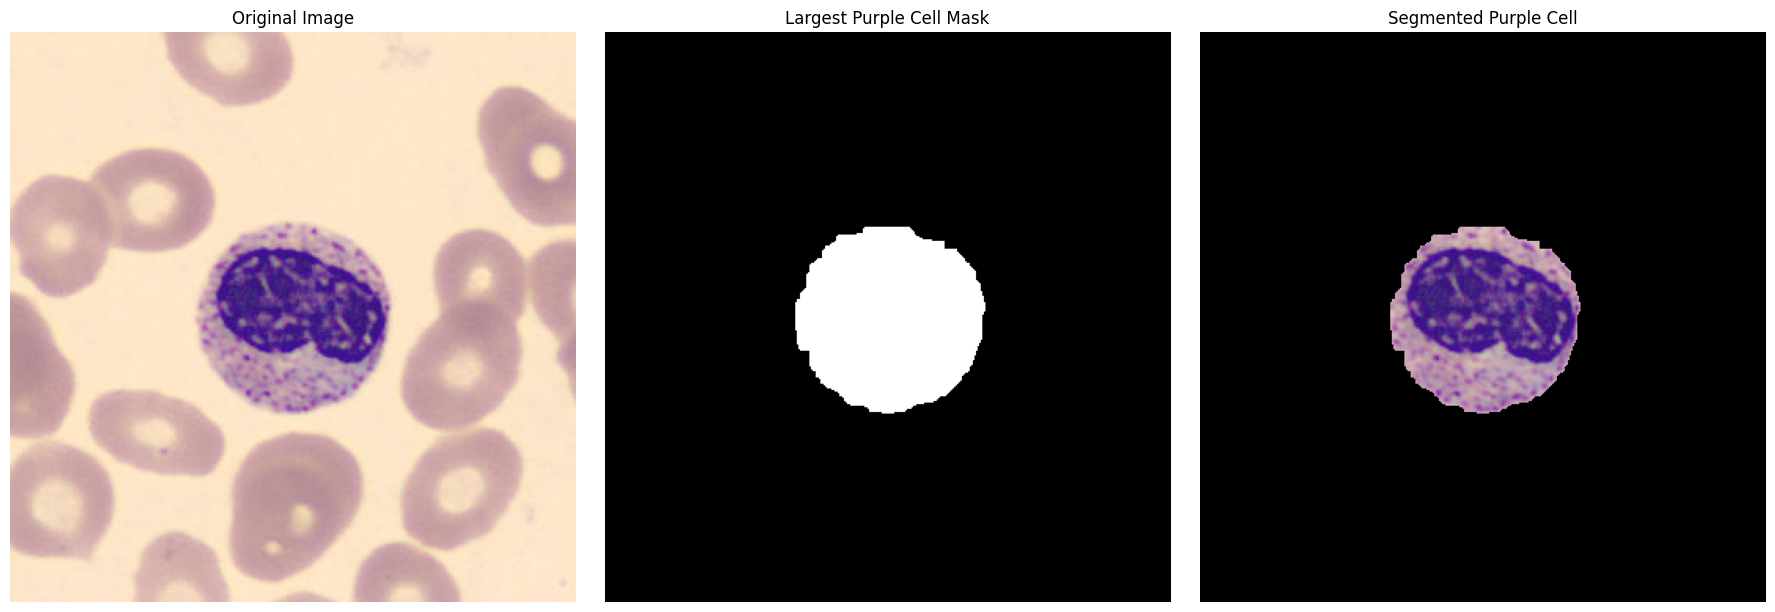

Found 2895 images to process...
[1/2895] Processing MY_818396.jpg...
  ✓ Saved segmented_MY_818396.png
[2/2895] Processing MY_598679.jpg...
  ✓ Saved segmented_MY_598679.png
[3/2895] Processing MY_744972.jpg...
  ✓ Saved segmented_MY_744972.png
[4/2895] Processing PMY_725335.jpg...
  ✓ Saved segmented_PMY_725335.png
[5/2895] Processing MMY_3376.jpg...
  ✓ Saved segmented_MMY_3376.png
[6/2895] Processing MMY_686451.jpg...
  ✓ Saved segmented_MMY_686451.png
[7/2895] Processing MY_19278.jpg...
  ✓ Saved segmented_MY_19278.png
[8/2895] Processing MY_396433.jpg...
  ✓ Saved segmented_MY_396433.png
[9/2895] Processing PMY_233788.jpg...
  ✓ Saved segmented_PMY_233788.png
[10/2895] Processing MY_349045.jpg...
  ✓ Saved segmented_MY_349045.png
[11/2895] Processing MY_430911.jpg...
  ✓ Saved segmented_MY_430911.png
[12/2895] Processing MMY_661553.jpg...
  ✓ Saved segmented_MMY_661553.png
[13/2895] Processing MY_810709.jpg...
  ✓ Saved segmented_MY_810709.png
[14/2895] Processing MY_60036.jpg...


In [ ]:
def segment_purple_cell(image_path):
    """
    Segment the largest purple cell from a microscopy image.
    
    Args:
        image_path (str): Path to the input image
        
    Returns:
        tuple: Original image (RGB), segmentation mask, and segmented cell (RGB), success flag
    """
    try:
        # Load the image
        image = cv2.imread(image_path)
        
        # Check if image was loaded successfully
        if image is None:
            print(f"Could not load image from {image_path}")
            return None, None, None, False
            
        # Convert image to RGB for display
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Convert to different color spaces for better segmentation
        # HSV for color-based segmentation
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # LAB for better color discrimination
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        
        # Create multiple masks and combine them for better results
        # 1. HSV-based purple mask
        # Define range for purple color in HSV (adjusted range)
        lower_purple_hsv = np.array([120, 30, 50])  # More permissive lower bound
        upper_purple_hsv = np.array([170, 255, 255])  # Wider range to include more purples
        
        # Threshold the HSV image to get purple regions
        mask_hsv = cv2.inRange(hsv, lower_purple_hsv, upper_purple_hsv)
        
        # 2. Color difference in LAB space
        # Extract A and B channels where purple has distinctive values
        _, a, b = cv2.split(lab)
        
        # In LAB space, purple often has high negative A (green-red) values and negative B (blue-yellow) values
        # Create a mask based on these properties
        mask_lab = np.zeros_like(a)
        mask_lab[(a > 128) & (b < 128)] = 255  # Adjusted for purple (high A, low B)
        
        # Combine masks
        combined_mask = cv2.bitwise_or(mask_hsv, mask_lab)
        
        # Apply Gaussian blur to reduce noise
        blurred_mask = cv2.GaussianBlur(combined_mask, (5, 5), 0)
        
        # Apply Otsu's thresholding to get a binary mask
        _, binary_mask = cv2.threshold(blurred_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Perform morphological operations to clean up noise
        kernel = np.ones((5, 5), np.uint8)
        mask_cleaned = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
        mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_OPEN, kernel, iterations=1)
        
        # Find contours in the mask
        contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Create a clean mask for the final result
        final_mask = np.zeros_like(mask_cleaned)
        
        # If contours are found, process the largest one
        if contours:
            # Find the largest contour by area
            largest_contour = max(contours, key=cv2.contourArea)
            
            # Filter by minimum area to avoid noise
            if cv2.contourArea(largest_contour) > 500:
                # Create a mask with just the largest contour
                cv2.fillPoly(final_mask, [largest_contour], 255)
                
                # Fill any holes in the mask using a simpler method
                # This is more reliable than the previous approach that caused the error
                # First, find all holes (areas of black surrounded by white)
                holes_mask = np.zeros((final_mask.shape[0] + 2, final_mask.shape[1] + 2), np.uint8)
                
                # Make a copy of the mask to avoid modifying the original during flood fill
                mask_copy = final_mask.copy()
                
                # Fill holes using floodFill from the border
                cv2.floodFill(mask_copy, holes_mask, (0, 0), 255)
                
                # Invert the filled image
                mask_inv = cv2.bitwise_not(mask_copy)
                
                # Combine with original mask to get the final mask with holes filled
                final_mask = cv2.bitwise_or(final_mask, mask_inv)
                
                # Create the segmented image
                segmented = cv2.bitwise_and(image_rgb, image_rgb, mask=final_mask)
                
                return image_rgb, final_mask, segmented, True
            else:
                print("No large enough purple cell found in the image")
                return image_rgb, None, None, False
        else:
            print("No purple cells detected in the image")
            return image_rgb, None, None, False
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None, None, False


def save_segmented_cell_with_transparency(original_img, mask, filename, output_dir):
    """
    Save the segmented cell with transparent background
    
    Args:
        original_img: Original RGB image
        mask: Binary segmentation mask
        filename: Original filename
        output_dir: Directory to save the segmented image
    
    Returns:
        bool: True if successful, False otherwise
    """
    try:
        # Find contours in mask to get bounding box
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return False
            
        # Get the bounding rectangle of the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Create a transparent 4-channel image (RGBA) with the size of the bounding rectangle
        segmented_cropped = np.zeros((h, w, 4), dtype=np.uint8)
        
        # Create a mask for the cropped region
        cropped_mask = mask[y:y+h, x:x+w]
        
        # Convert original image back to BGR for consistency with OpenCV functions
        original_bgr = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
        
        # Copy RGB values from original image to the cropped region where mask is active
        for c in range(3):  # BGR channels
            segmented_cropped[:, :, c][cropped_mask == 255] = original_bgr[y:y+h, x:x+w][cropped_mask == 255, c]
        
        # Set alpha channel - transparent (0) where inactive, opaque (255) where active
        segmented_cropped[:, :, 3] = cropped_mask
        
        # Save the segmented image with transparent background
        output_filename = f"segmented_{os.path.splitext(filename)[0]}.png"
        output_path = os.path.join(output_dir, output_filename)
        
        # Save to PNG to preserve transparency
        cv2.imwrite(output_path, segmented_cropped)
        
        return True
    except Exception as e:
        print(f"Error saving segmented cell: {e}")
        return False


def process_all_images(image_dir):
    """
    Process all images in the directory and save segmented purple cells with transparency
    
    Args:
        image_dir (str): Directory containing input images
    """
    # Create output directory
    output_dir = os.path.join(os.path.dirname(image_dir), "segmented_cells")
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all image files
    image_paths = glob.glob(os.path.join(image_dir, "*.jpg")) + \
                 glob.glob(os.path.join(image_dir, "*.jpeg")) + \
                 glob.glob(os.path.join(image_dir, "*.png")) + \
                 glob.glob(os.path.join(image_dir, "*.tif")) + \
                 glob.glob(os.path.join(image_dir, "*.tiff"))
    
    if not image_paths:
        print(f"No images found in {image_dir}")
        return
    
    # Count for progress tracking
    total_images = len(image_paths)
    successful_segments = 0
    failed_segments = 0
    
    print(f"Found {total_images} images to process...")
    
    # Process each image
    for i, image_path in enumerate(image_paths):
        filename = os.path.basename(image_path)
        print(f"[{i+1}/{total_images}] Processing {filename}...")
        
        # Segment the image
        original, mask, segmented, success = segment_purple_cell(image_path)
        
        if success and mask is not None:
            # Save the segmented cell with transparency
            if save_segmented_cell_with_transparency(original, mask, filename, output_dir):
                print(f"  ✓ Saved segmented_{os.path.splitext(filename)[0]}.png")
                successful_segments += 1
            else:
                print(f"  ✗ Failed to save {filename}")
                failed_segments += 1
        else:
            print(f"  ✗ Failed to segment {filename}")
            failed_segments += 1
    
    print(f"\nSegmentation complete!")
    print(f"Successfully segmented: {successful_segments}/{total_images} images")
    print(f"Failed to segment: {failed_segments}/{total_images} images")
    print(f"Segmented images saved to: {output_dir}")


def process_random_image(image_folder, display_results=True):
    """
    Process a randomly selected image from the specified folder.
    
    Args:
        image_folder (str): Path to the folder containing images
        display_results (bool): Whether to display the results using matplotlib
    """
    # Validate the folder exists
    if not os.path.isdir(image_folder):
        print(f"Error: The folder {image_folder} does not exist.")
        return
        
    # Get list of all images in the folder
    image_files = [f for f in os.listdir(image_folder)
                  if f.lower().endswith((".jpg", ".jpeg", ".png", ".tif", ".tiff"))]
    
    if not image_files:
        print(f"No image files found in {image_folder}")
        return
        
    # Randomly select an image
    random_image = random.choice(image_files)
    image_path = os.path.join(image_folder, random_image)
    print(f"Processing image: {random_image}")
    
    try:
        # Process the image
        original, mask, segmented, success = segment_purple_cell(image_path)
        
        if not success or mask is None:
            print("Failed to segment purple cell in the selected image.")
            return
            
        # Create output directory for the single image
        output_dir = os.path.join(os.path.dirname(image_folder), "segmented_immunoglobin")
        os.makedirs(output_dir, exist_ok=True)
        
        # Save the segmented cell with transparency
        if save_segmented_cell_with_transparency(original, mask, random_image, output_dir):
            print(f"Saved segmented_{os.path.splitext(random_image)[0]}.png to {output_dir}")
            
            # Print statistics about the segmentation
            if np.any(mask > 0):
                pixel_count = np.sum(mask > 0)
                print(f"Segmented cell area: {pixel_count} pixels")
                
                # Calculate the percentage of the image occupied by the cell
                total_pixels = mask.shape[0] * mask.shape[1]
                percentage = (pixel_count / total_pixels) * 100
                print(f"Cell occupies {percentage:.2f}% of the image")
        else:
            print(f"Failed to save segmented image")
            
        # Display the results if requested
        if display_results:
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            axes[0].imshow(original)
            axes[0].set_title("Original Image")
            axes[0].axis("off")
            
            axes[1].imshow(mask, cmap='gray')
            axes[1].set_title("Largest Purple Cell Mask")
            axes[1].axis("off")
            
            axes[2].imshow(segmented)
            axes[2].set_title("Segmented Purple Cell")
            axes[2].axis("off")
            
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error processing image {random_image}: {e}")


# Example usage
if __name__ == "__main__":
    # Path to your folder containing immunoglobin blood cell images
    image_folder = "/Users/afnanag/projects/DH307/yolov11/segmentation/data/immunoglobin/images"
    
    # Choose one of the following:
    
    # 1. Process a single random image and display results
    process_random_image(image_folder)
    
    # 2. Process all images in the folder and save segmented cells
    process_all_images(image_folder)

## Lymphoblast

Selected random image: generated_880.jpg
Saved segmented_generated_880.png to /Users/afnanag/projects/DH307/yolov11/segmentation/data/lymphoblast/segmented_lymphoblasts


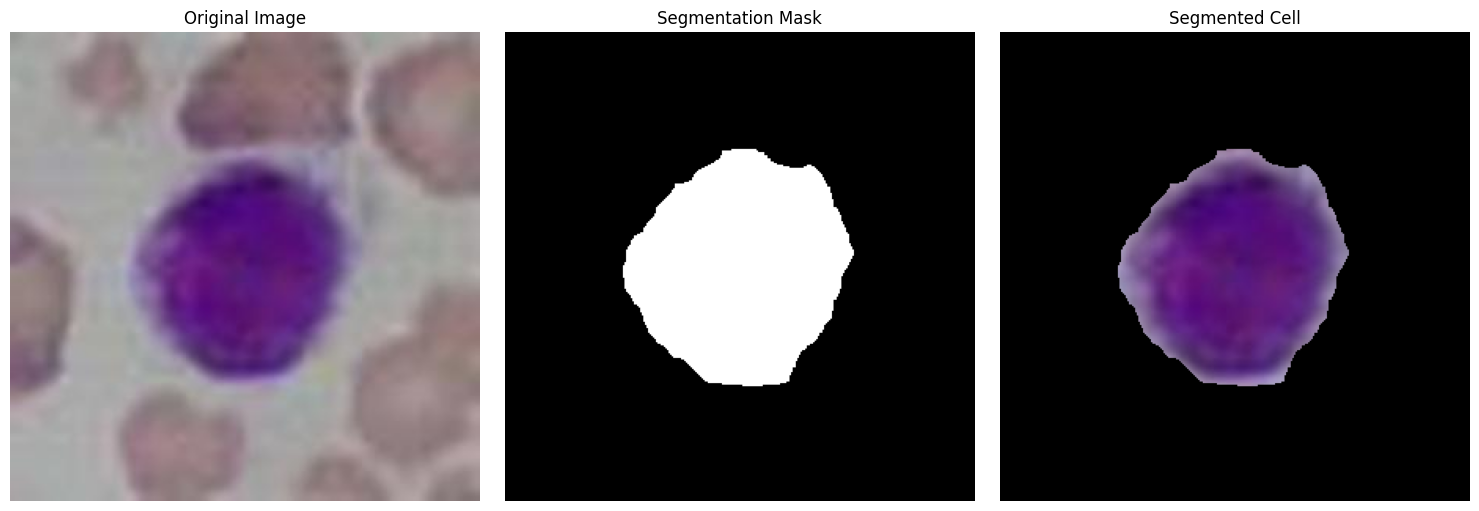

Found 870 images to process...
[1/870] Processing generated_392.jpg...
  ✓ Saved segmented_generated_392.png
[2/870] Processing generated_386.jpg...
  ✓ Saved segmented_generated_386.png
[3/870] Processing generated_351.jpg...
  ✓ Saved segmented_generated_351.png
[4/870] Processing generated_437.jpg...
  ✓ Saved segmented_generated_437.png
[5/870] Processing generated_423.jpg...
  ✓ Saved segmented_generated_423.png
[6/870] Processing generated_345.jpg...
  ✓ Saved segmented_generated_345.png
[7/870] Processing generated_190.jpg...
  ✓ Saved segmented_generated_190.png
[8/870] Processing generated_184.jpg...
  ✓ Saved segmented_generated_184.png
[9/870] Processing generated_812.jpg...
  ✓ Saved segmented_generated_812.png
[10/870] Processing generated_635.jpg...
  ✓ Saved segmented_generated_635.png
[11/870] Processing generated_153.jpg...
  ✓ Saved segmented_generated_153.png
[12/870] Processing generated_147.jpg...
  ✓ Saved segmented_generated_147.png
[13/870] Processing generated_

In [67]:
def segment_lymphoblast_simple(image_path):
    """
    A simple and robust approach to segment the purple lymphoblast from a microscopy image.
    
    Args:
        image_path (str): Path to the input image
    
    Returns:
        tuple: Original image, segmentation mask, segmented cell, and success flag
    """
    try:
        # Read the image
        img = cv2.imread(image_path)
        
        if img is None:
            print(f"Could not load image: {image_path}")
            return None, None, None, False
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Store original for output
        original = img.copy()
        
        # Extract RGB channels
        r, g, b = cv2.split(img)
        
        # Create a simple purple detector
        # Purple has high blue, some red, low green
        # Key insight: b > r > g for purple/blue stained cells
        
        # Create a mask where blue is dominant over green by a good margin
        blue_over_green = np.uint8((b > (g + 30)) * 255)
        
        # Create a mask where blue is also higher than red (to catch dark blues/purples)
        blue_over_red = np.uint8((b > r) * 255)
        
        # Combine masks
        purple_mask = cv2.bitwise_and(blue_over_green, blue_over_red)
        
        # Optional: Filter by absolute blue intensity (must be reasonably high)
        high_blue = np.uint8((b > 50) * 255)
        purple_mask = cv2.bitwise_and(purple_mask, high_blue)
        
        # Clean up the mask
        kernel = np.ones((3, 3), np.uint8)
        purple_mask = cv2.morphologyEx(purple_mask, cv2.MORPH_OPEN, kernel, iterations=1)
        purple_mask = cv2.morphologyEx(purple_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
        
        # Find contours
        contours, _ = cv2.findContours(purple_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Create final mask
        final_mask = np.zeros_like(purple_mask)
        
        # Find the largest purple contour (likely the lymphoblast)
        if contours:
            # Get the largest contour by area
            largest_contour = max(contours, key=cv2.contourArea)
            
            # Only use it if it's a reasonable size (avoid noise)
            area = cv2.contourArea(largest_contour)
            if area > 100:  # Adjust this threshold as needed
                cv2.drawContours(final_mask, [largest_contour], -1, 255, -1)
                
                # Apply the mask to get the segmented cell
                segmented = cv2.bitwise_and(original, original, mask=final_mask)
                
                return original, final_mask, segmented, True
            else:
                print(f"No sufficiently large lymphoblast detected in {image_path}")
                return original, None, None, False
        else:
            print(f"No lymphoblast contours detected in {image_path}")
            return original, None, None, False
    
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None, None, False


def save_segmented_cell_with_transparency(original_img, mask, filename, output_dir):
    """
    Save the segmented cell with transparent background
    
    Args:
        original_img: Original RGB image
        mask: Binary segmentation mask
        filename: Original filename
        output_dir: Directory to save the segmented image
    
    Returns:
        bool: True if successful, False otherwise
    """
    try:
        # Find contours in mask to get bounding box
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return False
            
        # Get the bounding rectangle of the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Create a transparent 4-channel image (RGBA) with the size of the bounding rectangle
        segmented_cropped = np.zeros((h, w, 4), dtype=np.uint8)
        
        # Create a mask for the cropped region
        cropped_mask = mask[y:y+h, x:x+w]
        
        # Convert original image back to BGR for consistency with OpenCV functions
        original_bgr = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
        
        # Copy RGB values from original image to the cropped region where mask is active
        for c in range(3):  # BGR channels
            segmented_cropped[:, :, c][cropped_mask == 255] = original_bgr[y:y+h, x:x+w][cropped_mask == 255, c]
        
        # Set alpha channel - transparent (0) where inactive, opaque (255) where active
        segmented_cropped[:, :, 3] = cropped_mask
        
        # Save the segmented image with transparent background
        output_filename = f"segmented_{os.path.splitext(filename)[0]}.png"
        output_path = os.path.join(output_dir, output_filename)
        
        # Save to PNG to preserve transparency
        cv2.imwrite(output_path, segmented_cropped)
        
        return True
    except Exception as e:
        print(f"Error saving segmented cell: {e}")
        return False


def process_all_images(image_dir):
    """
    Process all images in the directory and save segmented lymphoblasts with transparency
    
    Args:
        image_dir (str): Directory containing input images
    """
    # Create output directory
    output_dir = os.path.join(os.path.dirname(image_dir), "segmented_cells")
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all image files
    image_paths = glob.glob(os.path.join(image_dir, "*.jpg")) + \
                 glob.glob(os.path.join(image_dir, "*.jpeg")) + \
                 glob.glob(os.path.join(image_dir, "*.png")) + \
                 glob.glob(os.path.join(image_dir, "*.tif")) + \
                 glob.glob(os.path.join(image_dir, "*.tiff"))
    
    if not image_paths:
        print(f"No images found in {image_dir}")
        return
    
    # Count for progress tracking
    total_images = len(image_paths)
    successful_segments = 0
    failed_segments = 0
    
    print(f"Found {total_images} images to process...")
    
    # Process each image
    for i, image_path in enumerate(image_paths):
        filename = os.path.basename(image_path)
        print(f"[{i+1}/{total_images}] Processing {filename}...")
        
        # Segment the image
        original, mask, segmented, success = segment_lymphoblast_simple(image_path)
        
        if success and mask is not None:
            # Save the segmented cell with transparency
            if save_segmented_cell_with_transparency(original, mask, filename, output_dir):
                print(f"  ✓ Saved segmented_{os.path.splitext(filename)[0]}.png")
                successful_segments += 1
            else:
                print(f"  ✗ Failed to save {filename}")
                failed_segments += 1
        else:
            print(f"  ✗ Failed to segment {filename}")
            failed_segments += 1
    
    print(f"\nSegmentation complete!")
    print(f"Successfully segmented: {successful_segments}/{total_images} images")
    print(f"Failed to segment: {failed_segments}/{total_images} images")
    print(f"Segmented images saved to: {output_dir}")


def process_image(image_path, save_result=False):
    """
    Process a single image and display the results
    
    Args:
        image_path (str): Path to the image
        save_result (bool): Whether to save the segmented cell with transparency
    """
    try:
        # Process the image
        original, mask, segmented, success = segment_lymphoblast_simple(image_path)
        
        if not success or mask is None:
            print("Failed to segment the image.")
            return
            
        # Save the segmented cell if requested
        if save_result:
            # Create output directory
            output_dir = os.path.join(os.path.dirname(os.path.dirname(image_path)), "segmented_lymphoblasts")
            os.makedirs(output_dir, exist_ok=True)
            
            filename = os.path.basename(image_path)
            if save_segmented_cell_with_transparency(original, mask, filename, output_dir):
                print(f"Saved segmented_{os.path.splitext(filename)[0]}.png to {output_dir}")
        
        # Display results
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.imshow(original)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(mask, cmap='gray')
        plt.title('Segmentation Mask')
        plt.axis('off')
        
        plt.subplot(133)
        plt.imshow(segmented)
        plt.title('Segmented Cell')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        import traceback
        traceback.print_exc()


def process_random_image(image_dir, save_result=True):
    """
    Process a random image from the directory
    
    Args:
        image_dir (str): Directory containing input images
        save_result (bool): Whether to save the segmented cell with transparency
    """
    # Get all image files
    image_paths = glob.glob(os.path.join(image_dir, "*.jpg")) + \
                 glob.glob(os.path.join(image_dir, "*.jpeg")) + \
                 glob.glob(os.path.join(image_dir, "*.png")) + \
                 glob.glob(os.path.join(image_dir, "*.tif")) + \
                 glob.glob(os.path.join(image_dir, "*.tiff"))
    
    if not image_paths:
        print(f"No images found in {image_dir}")
        return
    
    # Select a random image
    random_image_path = random.choice(image_paths)
    print(f"Selected random image: {os.path.basename(random_image_path)}")
    
    # Process the image
    process_image(random_image_path, save_result)


# Run the code
if __name__ == "__main__":
    # Your image directory
    image_dir = "/Users/afnanag/projects/DH307/yolov11/segmentation/data/lymphoblast/images"
    
    # Choose one of the following:
    
    # 1. Process a random image and display results (with saving)
    process_random_image(image_dir, save_result=True)
    
    # 2. Process all images in the folder and save segmented cells
    process_all_images(image_dir)

## Monocyte

Processing 1 random images
Processing image 1/1: MO_261751.jpg
  Segmentation covers 19.40% of the image


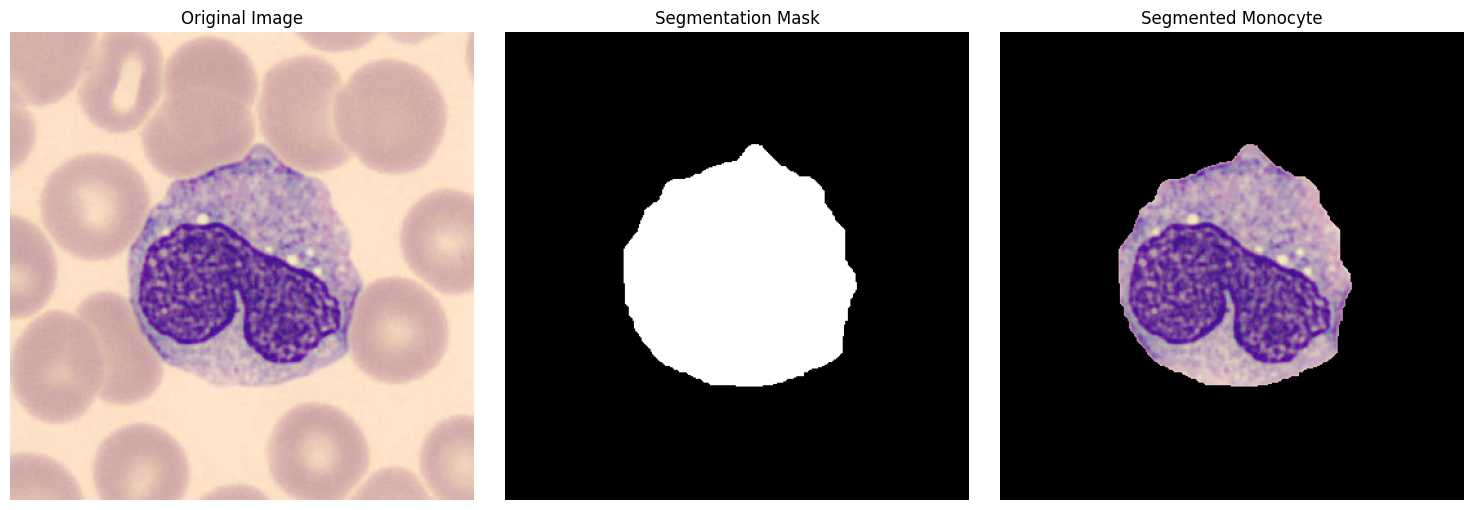


Processed 1 images: 1 successful, 0 failed


In [3]:
def segment_monocyte(image_path):
    """
    Segment monocytes from microscopy images based on color and size characteristics.
    Keep only the single largest connected component in the final mask.
    
    Args:
        image_path (str): Path to the input image
    
    Returns:
        tuple: Original image, segmentation mask, and segmented cell
    """
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image from {image_path}")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original = img.copy()
    
    # Step 1: Extract the purple/blue components of monocytes
    # Convert to HSV for better color separation
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Define range for purple/blue color (monocyte nucleus)
    lower_purple = np.array([120, 30, 100])
    upper_purple = np.array([170, 255, 255])
    
    # Create a mask for purple regions
    purple_mask = cv2.inRange(hsv, lower_purple, upper_purple)
    
    # Step 2: Apply morphological operations to clean the mask
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(purple_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Dilate to include cytoplasm around nucleus
    dilated = cv2.dilate(opening, kernel, iterations=3)
    
    # Step 3: Find contours in the mask
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Step 4: Keep only the largest contour by area
    mask = np.zeros_like(dilated)
    img_area = img.shape[0] * img.shape[1]
    
    # Filter out small noise contours
    valid_contours = [contour for contour in contours if cv2.contourArea(contour) > (0.01 * img_area)]
    
    if valid_contours:
        # Find the largest contour
        largest_contour = max(valid_contours, key=cv2.contourArea)
        # Draw only the largest contour on the mask
        cv2.drawContours(mask, [largest_contour], -1, 255, -1)
    
    # Step 5: Refine the segmentation
    # Convert to grayscale for additional processing
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply GrabCut algorithm using the mask as initial estimate
    if np.sum(mask) > 0:
        # Create mask for GrabCut
        grabcut_mask = np.zeros(img.shape[:2], np.uint8)
        grabcut_mask[:] = cv2.GC_PR_BGD  # Set all to probable background
        grabcut_mask[mask > 0] = cv2.GC_PR_FGD  # Set mask area to probable foreground
        
        # Define bounding rectangle around the mask
        x, y, w, h = cv2.boundingRect(mask)
        rect = (x, y, w, h)
        
        # Arrays for GrabCut
        bgdModel = np.zeros((1, 65), np.float64)
        fgdModel = np.zeros((1, 65), np.float64)
        
        # Apply GrabCut
        try:
            cv2.grabCut(img, grabcut_mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)
            
            # Create final mask
            final_mask = np.where((grabcut_mask == cv2.GC_FGD) | (grabcut_mask == cv2.GC_PR_FGD), 255, 0).astype('uint8')
        except:
            # Fallback if GrabCut fails
            final_mask = mask.copy()
    else:
        final_mask = mask.copy()
    
    # Step 6: Final cleanup with morphological operations
    # Fill holes in the mask
    kernel_close = np.ones((5, 5), np.uint8)
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel_close, iterations=2)
    
    # Step 7: Find connected components in the final mask and keep only the largest one
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(final_mask, connectivity=8)
    
    # Skip background (label 0)
    if num_labels > 1:
        # Find largest component by area (excluding background)
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        
        # Create a new mask containing only the largest component
        final_mask = np.zeros_like(final_mask)
        final_mask[labels == largest_label] = 255
    
    # Step 8: Apply the final mask to get the segmented monocyte
    segmented = cv2.bitwise_and(original, original, mask=final_mask)
    
    return original, final_mask, segmented

def evaluate_segmentation(original_image, predicted_mask, ground_truth_mask=None):
    """
    Evaluate the segmentation quality. If ground truth is provided, calculate metrics.
    Otherwise, provide a visual assessment.
    
    Args:
        original_image: Original input image
        predicted_mask: Mask generated by the algorithm
        ground_truth_mask: Optional ground truth mask for comparison
        
    Returns:
        dict: Evaluation metrics or None if no ground truth provided
    """
    # If ground truth is provided, calculate metrics
    if ground_truth_mask is not None:
        # Convert masks to binary
        pred_binary = (predicted_mask > 0).astype(np.uint8)
        gt_binary = (ground_truth_mask > 0).astype(np.uint8)
        
        # Calculate Intersection over Union (IoU)
        intersection = np.logical_and(pred_binary, gt_binary).sum()
        union = np.logical_or(pred_binary, gt_binary).sum()
        iou = intersection / union if union > 0 else 0
        
        # Calculate Dice coefficient
        dice = (2 * intersection) / (pred_binary.sum() + gt_binary.sum()) if (pred_binary.sum() + gt_binary.sum()) > 0 else 0
        
        return {
            "IoU": iou,
            "Dice": dice,
            "Pixel Accuracy": (pred_binary == gt_binary).sum() / pred_binary.size
        }
    
    # If no ground truth, return visual assessment
    # Calculate percentage of image that is segmented
    segmented_percentage = (predicted_mask > 0).sum() / predicted_mask.size
    
    # Check if mask is empty or too small
    if segmented_percentage < 0.01:
        return "Warning: Segmentation mask is very small or empty"
    
    # Check if mask is too large
    if segmented_percentage > 0.5:
        return "Warning: Segmentation mask is very large (>50% of image)"
    
    return f"Segmentation covers {segmented_percentage:.2%} of the image"

def process_image_batch(image_dir, output_dir=None, sample_size=None):
    """
    Process multiple images and optionally save results
    
    Args:
        image_dir (str): Directory containing input images
        output_dir (str, optional): Directory to save output images
        sample_size (int, optional): Number of random images to process, None for all
    """
    # Get all image files
    image_files = glob.glob(os.path.join(image_dir, "*.jpg")) + \
                 glob.glob(os.path.join(image_dir, "*.jpeg")) + \
                 glob.glob(os.path.join(image_dir, "*.png"))
    
    if not image_files:
        print(f"No images found in {image_dir}")
        return
    
    # Select random sample if specified
    if sample_size and sample_size < len(image_files):
        image_paths = random.sample(image_files, sample_size)
        print(f"Processing {sample_size} random images")
    else:
        image_paths = image_files
        print(f"Processing all {len(image_paths)} images")
    
    # Create output directory if specified
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(os.path.join(output_dir, "masks"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "segmented"), exist_ok=True)
    
    # Process each image
    results = []
    for i, image_path in enumerate(image_paths):
        try:
            filename = os.path.basename(image_path)
            print(f"Processing image {i+1}/{len(image_paths)}: {filename}")
            
            # Process the image
            original, mask, segmented = segment_monocyte(image_path)
            
            # Evaluate segmentation
            evaluation = evaluate_segmentation(original, mask)
            if isinstance(evaluation, str):
                print(f"  {evaluation}")
            
            # Add to results
            results.append({
                "filename": filename,
                "status": "success",
                "evaluation": evaluation
            })
            
            # Save results if output directory is specified
            if output_dir:
                base_name = os.path.splitext(filename)[0]
                
                # Save mask
                cv2.imwrite(
                    os.path.join(output_dir, "masks", f"{base_name}_mask.png"), 
                    mask
                )
                
                # Save segmented image (convert RGB to BGR for OpenCV)
                segmented_bgr = cv2.cvtColor(segmented, cv2.COLOR_RGB2BGR)
                cv2.imwrite(
                    os.path.join(output_dir, "segmented", f"{base_name}_segmented.png"), 
                    segmented_bgr
                )
                
                # Save visualization
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(original)
                axes[0].set_title('Original')
                axes[0].axis('off')
                
                axes[1].imshow(mask, cmap='gray')
                axes[1].set_title('Mask')
                axes[1].axis('off')
                
                axes[2].imshow(segmented)
                axes[2].set_title('Segmented')
                axes[2].axis('off')
                
                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, f"{base_name}_results.png"))
                plt.close()
            
            # Display results for interactive use
            else:
                plt.figure(figsize=(15, 5))
                
                plt.subplot(131)
                plt.imshow(original)
                plt.title('Original Image')
                plt.axis('off')
                
                plt.subplot(132)
                plt.imshow(mask, cmap='gray')
                plt.title('Segmentation Mask')
                plt.axis('off')
                
                plt.subplot(133)
                plt.imshow(segmented)
                plt.title('Segmented Monocyte')
                plt.axis('off')
                
                plt.tight_layout()
                plt.show()
                
        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")
            results.append({
                "filename": os.path.basename(image_path),
                "status": "failed",
                "error": str(e)
            })
    
    # Print summary
    success_count = sum(1 for r in results if r["status"] == "success")
    print(f"\nProcessed {len(results)} images: {success_count} successful, {len(results) - success_count} failed")
    
    return results

def debug_segmentation(image_path):
    """
    Debug segmentation by showing intermediate steps
    
    Args:
        image_path (str): Path to the input image
    """
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image from {image_path}")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Step 1: Convert to HSV and extract purple components
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Define range for purple/blue color
    lower_purple = np.array([120, 30, 100])
    upper_purple = np.array([170, 255, 255])
    
    # Create a mask for purple regions
    purple_mask = cv2.inRange(hsv, lower_purple, upper_purple)
    
    # Step 2: Apply morphological operations
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(purple_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    dilated = cv2.dilate(opening, kernel, iterations=3)
    
    # Step 3: Find contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create image with contours
    contour_img = img.copy()
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
    
    # Step 4: Filter contours by area
    mask = np.zeros_like(dilated)
    img_area = img.shape[0] * img.shape[1]
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > (0.03 * img_area) and area < (0.15 * img_area):
            cv2.drawContours(mask, [contour], -1, 255, -1)
    
    # Step 5: Final result
    final_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=2)
    segmented = cv2.bitwise_and(img, img, mask=final_mask)
    
    # Display all intermediate steps
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    axes[0, 0].imshow(img)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Display HSV channels
    axes[0, 1].imshow(hsv[:,:,0], cmap='hsv')
    axes[0, 1].set_title('Hue Channel')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(purple_mask, cmap='gray')
    axes[0, 2].set_title('Purple Mask')
    axes[0, 2].axis('off')
    
    axes[0, 3].imshow(opening, cmap='gray')
    axes[0, 3].set_title('Opening')
    axes[0, 3].axis('off')
    
    axes[1, 0].imshow(dilated, cmap='gray')
    axes[1, 0].set_title('Dilated Mask')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(contour_img)
    axes[1, 1].set_title('Contours')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(final_mask, cmap='gray')
    axes[1, 2].set_title('Final Mask')
    axes[1, 2].axis('off')
    
    axes[1, 3].imshow(segmented)
    axes[1, 3].set_title('Segmented Cell')
    axes[1, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the code
if __name__ == "__main__":
    # Your image directory
    image_dir = "/Users/afnanag/projects/DH307/yolov11/segmentation/data/monocyte/images"
    
    # Example usage options:
    
    # Option 1: Process a single random image with visualization
    process_image_batch(image_dir, sample_size=1)
    
    # Option 2: Debug a specific image to see all processing steps
    # debug_segmentation("/path/to/specific/image.jpg")
    
    # Option 3: Process all images and save results
    # output_dir = "/Users/afnanag/projects/DH307/yolov11/segmentation/output"
    # process_image_batch(image_dir, output_dir=output_dir)

Selected random image: MO_291599.jpg
Saved segmented_MO_291599.png to /Users/afnanag/projects/DH307/yolov11/segmentation/data/monocyte/segmented_monocytes


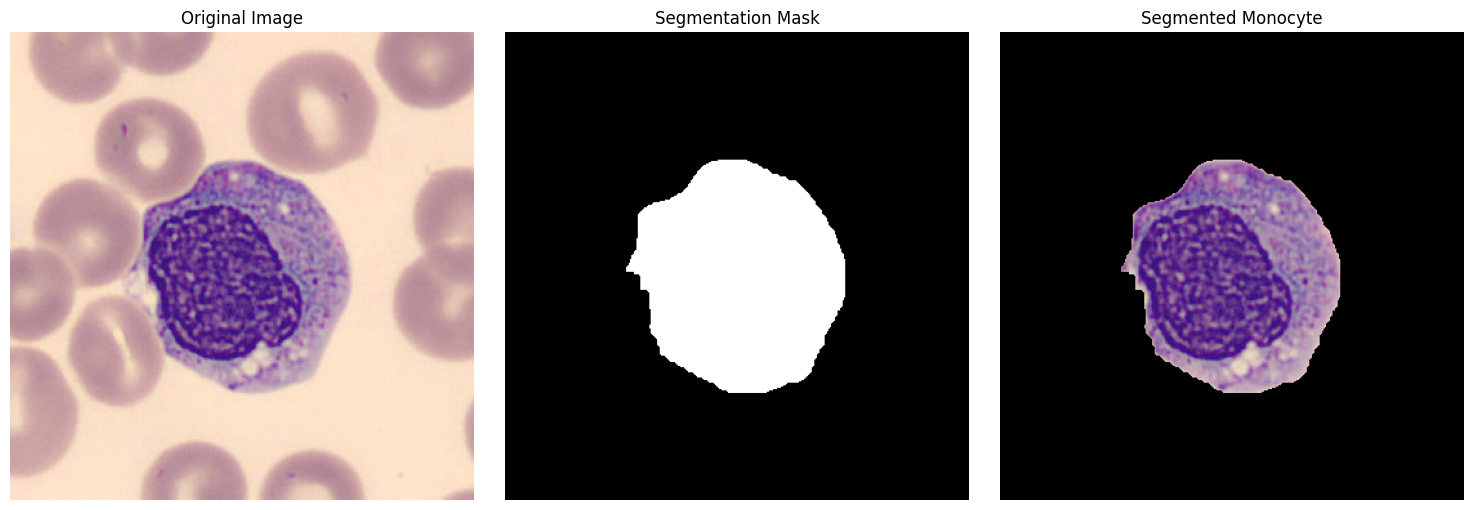

Found 1420 images to process...
[1/1420] Processing MO_648815.jpg...
  ✓ Saved segmented_MO_648815.png
[2/1420] Processing MO_405775.jpg...
  ✓ Saved segmented_MO_405775.png
[3/1420] Processing MO_36319.jpg...
  ✓ Saved segmented_MO_36319.png
[4/1420] Processing MO_519360.jpg...
  ✓ Saved segmented_MO_519360.png
[5/1420] Processing MO_810901.jpg...
  ✓ Saved segmented_MO_810901.png
[6/1420] Processing MO_775570.jpg...
  ✓ Saved segmented_MO_775570.png
[7/1420] Processing MO_600892.jpg...
  ✓ Saved segmented_MO_600892.png
[8/1420] Processing MO_985517.jpg...
  ✓ Saved segmented_MO_985517.png
[9/1420] Processing MO_888999.jpg...
  ✓ Saved segmented_MO_888999.png
[10/1420] Processing MO_195608.jpg...
  ✓ Saved segmented_MO_195608.png
[11/1420] Processing MO_947642.jpg...
  ✓ Saved segmented_MO_947642.png
[12/1420] Processing MO_991562.jpg...
  ✓ Saved segmented_MO_991562.png
[13/1420] Processing MO_469644.jpg...
  ✓ Saved segmented_MO_469644.png
[14/1420] Processing MO_357283.jpg...
  ✓ S

In [4]:
def save_segmented_monocyte_with_transparency(original_img, mask, filename, output_dir):
    """
    Save the segmented monocyte with transparent background
    
    Args:
        original_img: Original RGB image
        mask: Binary segmentation mask
        filename: Original filename
        output_dir: Directory to save the segmented image
    
    Returns:
        bool: True if successful, False otherwise
    """
    try:
        # Find contours in mask to get bounding box
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return False
            
        # Get the bounding rectangle of the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Create a transparent 4-channel image (RGBA) with the size of the bounding rectangle
        segmented_cropped = np.zeros((h, w, 4), dtype=np.uint8)
        
        # Create a mask for the cropped region
        cropped_mask = mask[y:y+h, x:x+w]
        
        # Convert original image back to BGR for consistency with OpenCV functions
        original_bgr = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
        
        # Copy RGB values from original image to the cropped region where mask is active
        for c in range(3):  # BGR channels
            segmented_cropped[:, :, c][cropped_mask == 255] = original_bgr[y:y+h, x:x+w][cropped_mask == 255, c]
        
        # Set alpha channel - transparent (0) where inactive, opaque (255) where active
        segmented_cropped[:, :, 3] = cropped_mask
        
        # Save the segmented image with transparent background
        output_filename = f"segmented_{os.path.splitext(filename)[0]}.png"
        output_path = os.path.join(output_dir, output_filename)
        
        # Save to PNG to preserve transparency
        cv2.imwrite(output_path, segmented_cropped)
        
        return True
    except Exception as e:
        print(f"Error saving segmented cell: {e}")
        return False


def process_all_monocyte_images(image_dir):
    """
    Process all images in the directory and save segmented monocytes with transparency
    
    Args:
        image_dir (str): Directory containing input images
    """
    # Create output directory
    output_dir = os.path.join(os.path.dirname(image_dir), "segmented_cells")
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all image files
    image_paths = glob.glob(os.path.join(image_dir, "*.jpg")) + \
                 glob.glob(os.path.join(image_dir, "*.jpeg")) + \
                 glob.glob(os.path.join(image_dir, "*.png")) + \
                 glob.glob(os.path.join(image_dir, "*.tif")) + \
                 glob.glob(os.path.join(image_dir, "*.tiff"))
    
    if not image_paths:
        print(f"No images found in {image_dir}")
        return
    
    # Count for progress tracking
    total_images = len(image_paths)
    successful_segments = 0
    failed_segments = 0
    
    print(f"Found {total_images} images to process...")
    
    # Process each image
    for i, image_path in enumerate(image_paths):
        filename = os.path.basename(image_path)
        print(f"[{i+1}/{total_images}] Processing {filename}...")
        
        # Segment the image
        try:
            original, mask, segmented = segment_monocyte(image_path)
            
            # Save the segmented cell with transparency
            if save_segmented_monocyte_with_transparency(original, mask, filename, output_dir):
                print(f"  ✓ Saved segmented_{os.path.splitext(filename)[0]}.png")
                successful_segments += 1
            else:
                print(f"  ✗ Failed to save {filename}")
                failed_segments += 1
        except Exception as e:
            print(f"  ✗ Failed to segment {filename}: {e}")
            failed_segments += 1
    
    print(f"\nSegmentation complete!")
    print(f"Successfully segmented: {successful_segments}/{total_images} images")
    print(f"Failed to segment: {failed_segments}/{total_images} images")
    print(f"Segmented images saved to: {output_dir}")


def process_single_monocyte_image(image_path, save_result=False):
    """
    Process a single monocyte image and display the results
    
    Args:
        image_path (str): Path to the image
        save_result (bool): Whether to save the segmented cell with transparency
    """
    try:
        # Process the image
        original, mask, segmented = segment_monocyte(image_path)
        
        # Save the segmented cell if requested
        if save_result:
            # Create output directory
            output_dir = os.path.join(os.path.dirname(os.path.dirname(image_path)), "segmented_monocytes")
            os.makedirs(output_dir, exist_ok=True)
            
            filename = os.path.basename(image_path)
            if save_segmented_monocyte_with_transparency(original, mask, filename, output_dir):
                print(f"Saved segmented_{os.path.splitext(filename)[0]}.png to {output_dir}")
        
        # Display results
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.imshow(original)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(mask, cmap='gray')
        plt.title('Segmentation Mask')
        plt.axis('off')
        
        plt.subplot(133)
        plt.imshow(segmented)
        plt.title('Segmented Monocyte')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        import traceback
        traceback.print_exc()


def process_random_monocyte_image(image_dir, save_result=True):
    """
    Process a random monocyte image from the directory
    
    Args:
        image_dir (str): Directory containing input images
        save_result (bool): Whether to save the segmented cell with transparency
    """
    # Get all image files
    image_paths = glob.glob(os.path.join(image_dir, "*.jpg")) + \
                 glob.glob(os.path.join(image_dir, "*.jpeg")) + \
                 glob.glob(os.path.join(image_dir, "*.png")) + \
                 glob.glob(os.path.join(image_dir, "*.tif")) + \
                 glob.glob(os.path.join(image_dir, "*.tiff"))
    
    if not image_paths:
        print(f"No images found in {image_dir}")
        return
    
    # Select a random image
    random_image_path = random.choice(image_paths)
    print(f"Selected random image: {os.path.basename(random_image_path)}")
    
    # Process the image
    process_single_monocyte_image(random_image_path, save_result)


# Run the code
if __name__ == "__main__":
    # Your image directory
    image_dir = "/Users/afnanag/projects/DH307/yolov11/segmentation/data/monocyte/images"
    
    # Choose one of the following:
    
    # 1. Process a random image and display results (with saving)
    process_random_monocyte_image(image_dir, save_result=True)
    
    # 2. Process all images in the folder and save segmented cells
    process_all_monocyte_images(image_dir)

## Neutrophil

Selected random image: BNE_810657.jpg


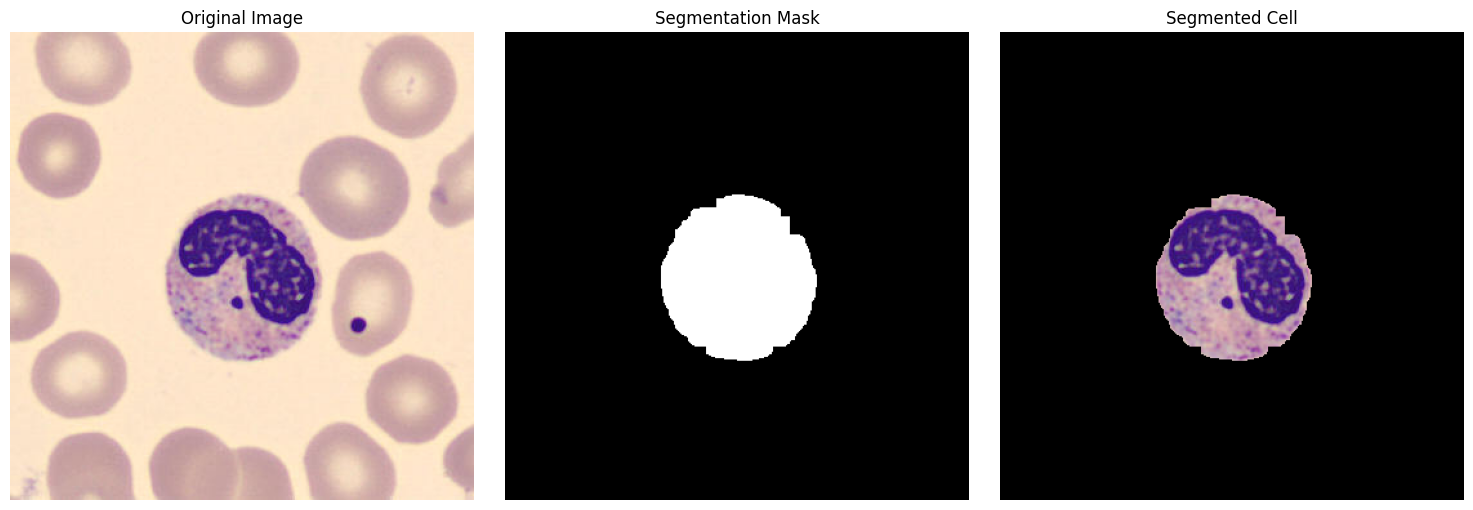

In [12]:
def segment_white_blood_cell(image_path):
    """
    Segment the central white blood cell from a microscopy image.
    
    Args:
        image_path (str): Path to the input image
    
    Returns:
        tuple: Original image, segmentation mask, and segmented cell
    """
    # Read the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    
    # Split the LAB image to different channels
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    # Merge the CLAHE enhanced L-channel back with the A and B channels
    enhanced_lab = cv2.merge((cl, a, b))
    
    # Convert back to RGB
    enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    
    # Convert to grayscale
    gray = cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Otsu's thresholding
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Perform morphological operations to clean up the mask
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Find contours
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a mask
    mask = np.zeros_like(opening)
    
    # If contours exist
    if contours:
        # Find the central contour (assuming the WBC is in the center)
        center_x, center_y = img.shape[1] // 2, img.shape[0] // 2
        closest_contour = None
        min_distance = float('inf')
        
        for contour in contours:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                distance = np.sqrt((cx - center_x)**2 + (cy - center_y)**2)
                area = cv2.contourArea(contour)
                
                # Filter by area to avoid small noise contours
                if area > 500 and distance < min_distance:
                    min_distance = distance
                    closest_contour = contour
        
        # Draw the central contour and fill it
        if closest_contour is not None:
            cv2.fillPoly(mask, [closest_contour], 255)
    
    # Apply watershed algorithm for better segmentation
    # Marker labelling
    ret, markers = cv2.connectedComponents(mask)
    
    # Add 1 to all labels so that background is not 0, but 1
    markers = markers + 1
    
    # Mark the region of unknown with 0
    markers[thresh == 0] = 0
    
    # Apply watershed
    markers = cv2.watershed(img, markers)
    
    # Create final mask
    final_mask = np.zeros_like(gray)
    final_mask[markers == 2] = 255
    
    # Fill holes in the final mask
    # Method 1: Using morphological operations
    kernel_close = np.ones((5, 5), np.uint8)
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel_close, iterations=3)
    
    # Method 2: Using contour filling
    contours_fill, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_mask_filled = np.zeros_like(final_mask)
    for contour in contours_fill:
        cv2.fillPoly(final_mask_filled, [contour], 255)
    
    # Use the filled mask
    final_mask = final_mask_filled
    
    # Apply mask to original image to get the segmented cell
    segmented = cv2.bitwise_and(img, img, mask=final_mask)
    
    return img, final_mask, segmented

def process_random_image(image_dir):
    """
    Process a random image from the directory and display the original, mask, and segmented image
    
    Args:
        image_dir (str): Directory containing input images
    """
    # Get all image files
    image_paths = glob.glob(os.path.join(image_dir, "*.jpg")) + \
                 glob.glob(os.path.join(image_dir, "*.jpeg")) + \
                 glob.glob(os.path.join(image_dir, "*.png"))
    
    if not image_paths:
        print(f"No images found in {image_dir}")
        return
    
    # Select a random image
    random_image_path = random.choice(image_paths)
    print(f"Selected random image: {os.path.basename(random_image_path)}")
    
    try:
        # Process the image
        original, mask, segmented = segment_white_blood_cell(random_image_path)
        
        # Display results
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.imshow(original)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(mask, cmap='gray')
        plt.title('Segmentation Mask')
        plt.axis('off')
        
        plt.subplot(133)
        plt.imshow(segmented)
        plt.title('Segmented Cell')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error processing {random_image_path}: {e}")

# Run the code
if __name__ == "__main__":
    # Your image directory
    image_dir = "/Users/afnanag/projects/DH307/yolov11/segmentation/data/neutrophil/images"
    
    # Process a random image
    process_random_image(image_dir)

Selected random image: BNE_332485.jpg
Saved segmented_BNE_332485.png to /Users/afnanag/projects/DH307/yolov11/segmentation/data/neutrophil/segmented_neutrophils


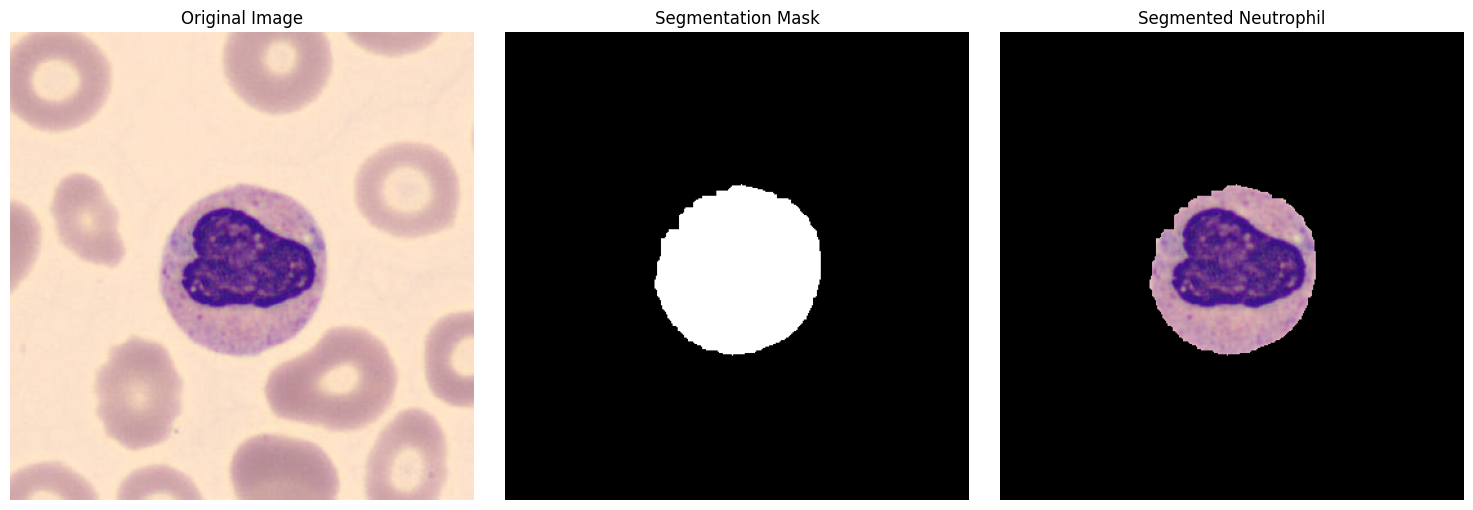

Found 3329 images to process...
[1/3329] Processing BNE_358773.jpg...
  ✓ Saved segmented_BNE_358773.png
[2/3329] Processing SNE_183410.jpg...
  ✓ Saved segmented_SNE_183410.png
[3/3329] Processing BNE_295701.jpg...
  ✓ Saved segmented_BNE_295701.png
[4/3329] Processing SNE_30327.jpg...
  ✓ Saved segmented_SNE_30327.png
[5/3329] Processing SNE_342586.jpg...
  ✓ Saved segmented_SNE_342586.png
[6/3329] Processing SNE_485296.jpg...
  ✓ Saved segmented_SNE_485296.png
[7/3329] Processing SNE_142258.jpg...
  ✓ Saved segmented_SNE_142258.png
[8/3329] Processing BNE_128562.jpg...
  ✓ Saved segmented_BNE_128562.png
[9/3329] Processing BNE_983955.jpg...
  ✓ Saved segmented_BNE_983955.png
[10/3329] Processing SNE_925481.jpg...
  ✓ Saved segmented_SNE_925481.png
[11/3329] Processing SNE_182040.jpg...
  ✓ Saved segmented_SNE_182040.png
[12/3329] Processing SNE_483803.jpg...
  ✓ Saved segmented_SNE_483803.png
[13/3329] Processing SNE_450483.jpg...
  ✓ Saved segmented_SNE_450483.png
[14/3329] Process

In [ ]:
def save_segmented_neutrophil_with_transparency(original_img, mask, filename, output_dir):
    """
    Save the segmented neutrophil with transparent background
    
    Args:
        original_img: Original RGB image
        mask: Binary segmentation mask
        filename: Original filename
        output_dir: Directory to save the segmented image
    
    Returns:
        bool: True if successful, False otherwise
    """
    try:
        # Find contours in mask to get bounding box
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return False
            
        # Get the bounding rectangle of the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Create a transparent 4-channel image (RGBA) with the size of the bounding rectangle
        segmented_cropped = np.zeros((h, w, 4), dtype=np.uint8)
        
        # Create a mask for the cropped region
        cropped_mask = mask[y:y+h, x:x+w]
        
        # Convert original image back to BGR for consistency with OpenCV functions
        original_bgr = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
        
        # Copy RGB values from original image to the cropped region where mask is active
        for c in range(3):  # BGR channels
            segmented_cropped[:, :, c][cropped_mask == 255] = original_bgr[y:y+h, x:x+w][cropped_mask == 255, c]
        
        # Set alpha channel - transparent (0) where inactive, opaque (255) where active
        segmented_cropped[:, :, 3] = cropped_mask
        
        # Save the segmented image with transparent background
        output_filename = f"segmented_{os.path.splitext(filename)[0]}.png"
        output_path = os.path.join(output_dir, output_filename)
        
        # Save to PNG to preserve transparency
        cv2.imwrite(output_path, segmented_cropped)
        
        return True
    except Exception as e:
        print(f"Error saving segmented cell: {e}")
        return False


def process_all_neutrophil_images(image_dir):
    """
    Process all images in the directory and save segmented neutrophils with transparency
    
    Args:
        image_dir (str): Directory containing input images
    """
    # Create output directory
    output_dir = os.path.join(os.path.dirname(image_dir), "segmented_cells")
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all image files
    image_paths = glob.glob(os.path.join(image_dir, "*.jpg")) + \
                 glob.glob(os.path.join(image_dir, "*.jpeg")) + \
                 glob.glob(os.path.join(image_dir, "*.png")) + \
                 glob.glob(os.path.join(image_dir, "*.tif")) + \
                 glob.glob(os.path.join(image_dir, "*.tiff"))
    
    if not image_paths:
        print(f"No images found in {image_dir}")
        return
    
    # Count for progress tracking
    total_images = len(image_paths)
    successful_segments = 0
    failed_segments = 0
    
    print(f"Found {total_images} images to process...")
    
    # Process each image
    for i, image_path in enumerate(image_paths):
        filename = os.path.basename(image_path)
        print(f"[{i+1}/{total_images}] Processing {filename}...")
        
        try:
            # Segment the image
            original, mask, segmented = segment_white_blood_cell(image_path)
            
            # Save the segmented cell with transparency
            if save_segmented_neutrophil_with_transparency(original, mask, filename, output_dir):
                print(f"  ✓ Saved segmented_{os.path.splitext(filename)[0]}.png")
                successful_segments += 1
            else:
                print(f"  ✗ Failed to save {filename}")
                failed_segments += 1
        except Exception as e:
            print(f"  ✗ Failed to segment {filename}: {e}")
            failed_segments += 1
    
    print(f"\nSegmentation complete!")
    print(f"Successfully segmented: {successful_segments}/{total_images} images")
    print(f"Failed to segment: {failed_segments}/{total_images} images")
    print(f"Segmented images saved to: {output_dir}")


def process_single_neutrophil_image(image_path, save_result=False):
    """
    Process a single neutrophil image and display the results
    
    Args:
        image_path (str): Path to the image
        save_result (bool): Whether to save the segmented cell with transparency
    """
    try:
        # Process the image
        original, mask, segmented = segment_white_blood_cell(image_path)
        
        # Save the segmented cell if requested
        if save_result:
            # Create output directory
            output_dir = os.path.join(os.path.dirname(os.path.dirname(image_path)), "segmented_neutrophils")
            os.makedirs(output_dir, exist_ok=True)
            
            filename = os.path.basename(image_path)
            if save_segmented_neutrophil_with_transparency(original, mask, filename, output_dir):
                print(f"Saved segmented_{os.path.splitext(filename)[0]}.png to {output_dir}")
        
        # Display results
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.imshow(original)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(mask, cmap='gray')
        plt.title('Segmentation Mask')
        plt.axis('off')
        
        plt.subplot(133)
        plt.imshow(segmented)
        plt.title('Segmented Neutrophil')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        import traceback
        traceback.print_exc()


def process_random_neutrophil_image(image_dir, save_result=True):
    """
    Process a random neutrophil image from the directory
    
    Args:
        image_dir (str): Directory containing input images
        save_result (bool): Whether to save the segmented cell with transparency
    """
    # Get all image files
    image_paths = glob.glob(os.path.join(image_dir, "*.jpg")) + \
                 glob.glob(os.path.join(image_dir, "*.jpeg")) + \
                 glob.glob(os.path.join(image_dir, "*.png")) + \
                 glob.glob(os.path.join(image_dir, "*.tif")) + \
                 glob.glob(os.path.join(image_dir, "*.tiff"))
    
    if not image_paths:
        print(f"No images found in {image_dir}")
        return
    
    # Select a random image
    random_image_path = random.choice(image_paths)
    print(f"Selected random image: {os.path.basename(random_image_path)}")
    
    # Process the image
    process_single_neutrophil_image(random_image_path, save_result)


# Run the code
if __name__ == "__main__":
    # Your image directory
    image_dir = "/Users/afnanag/projects/DH307/yolov11/segmentation/data/neutrophil/images"
    
    # Choose one of the following:
    
    # 1. Process a random image and display results (with saving)
    process_random_neutrophil_image(image_dir, save_result=True)
    
    # 2. Process all images in the folder and save segmented cells
    process_all_neutrophil_images(image_dir)

## Platelet

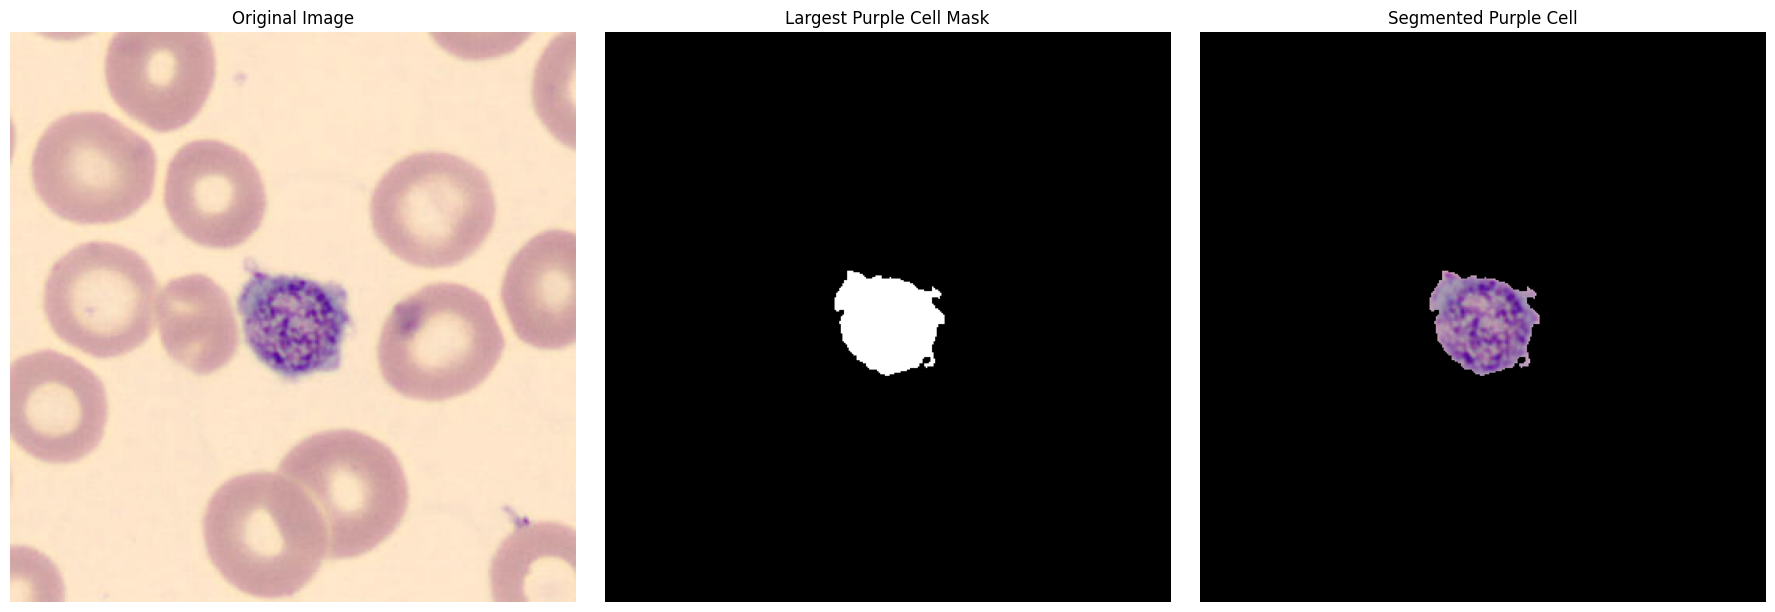

Randomly selected image: PLATELET_641661.jpg


In [15]:
# Folder containing images
image_folder = "/Users/afnanag/projects/DH307/yolov11/segmentation/data/platelet/images"

# Get list of all images in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith((".jpg", ".png", ".jpeg"))]

# Randomly select an image
random_image = random.choice(image_files)
image_path = os.path.join(image_folder, random_image)

# Load the randomly selected image
image = cv2.imread(image_path)

# Convert image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower_purple = np.array([130, 40, 40])  # Shifted slightly towards pink
upper_purple = np.array([170, 255, 255])

# Threshold the image to get only purple colors
mask = cv2.inRange(hsv, lower_purple, upper_purple)

kernel = np.ones((3, 3), np.uint8)  # Smaller kernel to preserve fine details

mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Find contours in the mask (fixed the typo here)
contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# If contours are found, keep only the largest one
if contours:
    largest_contour = max(contours, key=cv2.contourArea)  # Get the largest contour
    largest_mask = np.zeros_like(mask)  # Create an empty mask
    cv2.drawContours(largest_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)  # Fill the largest contour
    mask_cleaned = largest_mask  # Update the mask to keep only the largest detected object

# Convert image to RGB for display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create a segmented image by applying the mask
segmented = np.zeros_like(image)
segmented[mask_cleaned == 255] = image[mask_cleaned == 255]
segmented_rgb = cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB)

# Display the original image, segmentation mask, and segmented image
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image_rgb)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(mask_cleaned, cmap='gray')
axes[1].set_title("Largest Purple Cell Mask")
axes[1].axis("off")

axes[2].imshow(segmented_rgb)
axes[2].set_title("Segmented Purple Cell")
axes[2].axis("off")

plt.tight_layout()
plt.show()

# Print the randomly selected image name
print(f"Randomly selected image: {random_image}")

Selected random image: PLATELET_751726.jpg
Saved segmented_PLATELET_751726.png to /Users/afnanag/projects/DH307/yolov11/segmentation/data/platelet/segmented_platelets


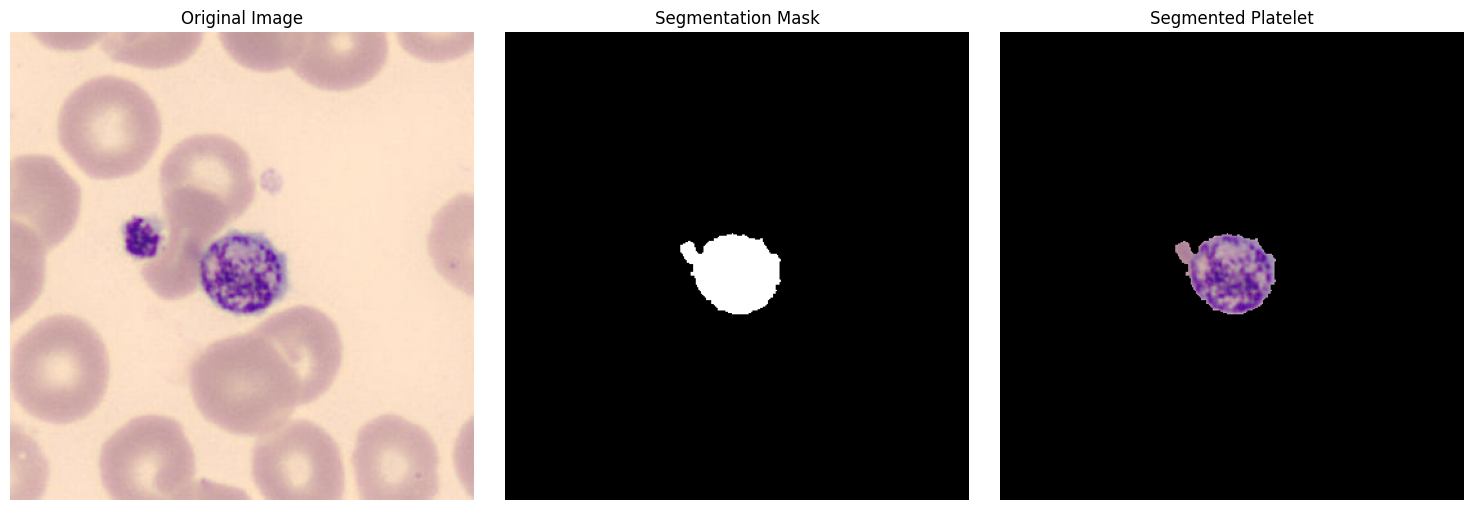

Found 2348 images to process...
[1/2348] Processing PLATELET_70358.jpg...
  ✓ Saved segmented_PLATELET_70358.png
[2/2348] Processing PLATELET_258296.jpg...
  ✓ Saved segmented_PLATELET_258296.png
[3/2348] Processing PLATELET_622915.jpg...
  ✓ Saved segmented_PLATELET_622915.png
[4/2348] Processing PLATELET_273761.jpg...
  ✓ Saved segmented_PLATELET_273761.png
[5/2348] Processing PLATELET_71052.jpg...
  ✓ Saved segmented_PLATELET_71052.png
[6/2348] Processing PLATELET_78710.jpg...
  ✓ Saved segmented_PLATELET_78710.png
[7/2348] Processing PLATELET_583187.jpg...
  ✓ Saved segmented_PLATELET_583187.png
[8/2348] Processing PLATELET_606647.jpg...
  ✓ Saved segmented_PLATELET_606647.png
[9/2348] Processing PLATELET_60177.jpg...
  ✓ Saved segmented_PLATELET_60177.png
[10/2348] Processing PLATELET_162165.jpg...
  ✓ Saved segmented_PLATELET_162165.png
[11/2348] Processing PLATELET_294887.jpg...
  ✓ Saved segmented_PLATELET_294887.png
[12/2348] Processing PLATELET_554634.jpg...
  ✓ Saved segment

In [16]:
def save_segmented_platelet_with_transparency(original_img, mask, filename, output_dir):
    """
    Save the segmented platelet with transparent background
    
    Args:
        original_img: Original RGB image
        mask: Binary segmentation mask
        filename: Original filename
        output_dir: Directory to save the segmented image
    
    Returns:
        bool: True if successful, False otherwise
    """
    try:
        # Find contours in mask to get bounding box
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return False
            
        # Get the bounding rectangle of the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Create a transparent 4-channel image (RGBA) with the size of the bounding rectangle
        segmented_cropped = np.zeros((h, w, 4), dtype=np.uint8)
        
        # Create a mask for the cropped region
        cropped_mask = mask[y:y+h, x:x+w]
        
        # Original image is in BGR format (from cv2.imread)
        # Copy BGR values from original image to the cropped region where mask is active
        for c in range(3):  # BGR channels
            segmented_cropped[:, :, c][cropped_mask == 255] = original_img[y:y+h, x:x+w][cropped_mask == 255, c]
        
        # Set alpha channel - transparent (0) where inactive, opaque (255) where active
        segmented_cropped[:, :, 3] = cropped_mask
        
        # Save the segmented image with transparent background
        output_filename = f"segmented_{os.path.splitext(filename)[0]}.png"
        output_path = os.path.join(output_dir, output_filename)
        
        # Save to PNG to preserve transparency
        cv2.imwrite(output_path, segmented_cropped)
        
        return True
    except Exception as e:
        print(f"Error saving segmented platelet: {e}")
        return False

def segment_platelet(image_path):
    """
    Segment a platelet from an image based on purple color detection
    
    Args:
        image_path: Path to the image file
        
    Returns:
        tuple: (original_image, mask, segmented_image)
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
        
    # Convert image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define purple color range
    lower_purple = np.array([130, 40, 40])  # Shifted slightly towards pink
    upper_purple = np.array([170, 255, 255])
    
    # Threshold the image to get only purple colors
    mask = cv2.inRange(hsv, lower_purple, upper_purple)
    
    # Clean up the mask with morphological operations
    kernel = np.ones((3, 3), np.uint8)  # Smaller kernel to preserve fine details
    mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Find contours in the mask
    contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # If contours are found, keep only the largest one
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)  # Get the largest contour
        largest_mask = np.zeros_like(mask)  # Create an empty mask
        cv2.drawContours(largest_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)  # Fill the largest contour
        mask_cleaned = largest_mask  # Update the mask to keep only the largest detected object
    
    # Create a segmented image by applying the mask
    segmented = np.zeros_like(image)
    segmented[mask_cleaned == 255] = image[mask_cleaned == 255]
    
    # Convert image to RGB for display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    segmented_rgb = cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB)
    
    return image_rgb, mask_cleaned, segmented_rgb

def process_single_platelet_image(image_path, save_result=False):
    """
    Process a single platelet image and display the results
    
    Args:
        image_path (str): Path to the image
        save_result (bool): Whether to save the segmented cell with transparency
    """
    try:
        # Process the image
        original, mask, segmented = segment_platelet(image_path)
        
        # Save the segmented cell if requested
        if save_result:
            # Create output directory
            output_dir = os.path.join(os.path.dirname(os.path.dirname(image_path)), "segmented_platelets")
            os.makedirs(output_dir, exist_ok=True)
            
            filename = os.path.basename(image_path)
            original_bgr = cv2.cvtColor(original, cv2.COLOR_RGB2BGR)  # Convert back to BGR for saving
            if save_segmented_platelet_with_transparency(original_bgr, mask, filename, output_dir):
                print(f"Saved segmented_{os.path.splitext(filename)[0]}.png to {output_dir}")
        
        # Display results
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.imshow(original)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(mask, cmap='gray')
        plt.title('Segmentation Mask')
        plt.axis('off')
        
        plt.subplot(133)
        plt.imshow(segmented)
        plt.title('Segmented Platelet')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        import traceback
        traceback.print_exc()

def process_random_platelet_image(image_dir, save_result=True):
    """
    Process a random platelet image from the directory
    
    Args:
        image_dir (str): Directory containing input images
        save_result (bool): Whether to save the segmented cell with transparency
    """
    # Get all image files
    image_paths = glob.glob(os.path.join(image_dir, "*.jpg")) + \
                 glob.glob(os.path.join(image_dir, "*.jpeg")) + \
                 glob.glob(os.path.join(image_dir, "*.png")) + \
                 glob.glob(os.path.join(image_dir, "*.tif")) + \
                 glob.glob(os.path.join(image_dir, "*.tiff"))
    
    if not image_paths:
        print(f"No images found in {image_dir}")
        return
    
    # Select a random image
    random_image_path = random.choice(image_paths)
    print(f"Selected random image: {os.path.basename(random_image_path)}")
    
    # Process the image
    process_single_platelet_image(random_image_path, save_result)

def process_all_platelet_images(image_dir):
    """
    Process all images in the directory and save segmented platelets with transparency
    
    Args:
        image_dir (str): Directory containing input images
    """
    # Create output directory
    output_dir = os.path.join(os.path.dirname(image_dir), "segmented_cells")
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all image files
    image_paths = glob.glob(os.path.join(image_dir, "*.jpg")) + \
                 glob.glob(os.path.join(image_dir, "*.jpeg")) + \
                 glob.glob(os.path.join(image_dir, "*.png")) + \
                 glob.glob(os.path.join(image_dir, "*.tif")) + \
                 glob.glob(os.path.join(image_dir, "*.tiff"))
    
    if not image_paths:
        print(f"No images found in {image_dir}")
        return
    
    # Count for progress tracking
    total_images = len(image_paths)
    successful_segments = 0
    failed_segments = 0
    
    print(f"Found {total_images} images to process...")
    
    # Process each image
    for i, image_path in enumerate(image_paths):
        filename = os.path.basename(image_path)
        print(f"[{i+1}/{total_images}] Processing {filename}...")
        
        try:
            # Segment the image
            original, mask, segmented = segment_platelet(image_path)
            
            # Original is RGB, need to convert back to BGR for OpenCV functions
            original_bgr = cv2.cvtColor(original, cv2.COLOR_RGB2BGR)
            
            # Save the segmented cell with transparency
            if save_segmented_platelet_with_transparency(original_bgr, mask, filename, output_dir):
                print(f"  ✓ Saved segmented_{os.path.splitext(filename)[0]}.png")
                successful_segments += 1
            else:
                print(f"  ✗ Failed to save {filename}")
                failed_segments += 1
        except Exception as e:
            print(f"  ✗ Failed to segment {filename}: {e}")
            failed_segments += 1
    
    print(f"\nSegmentation complete!")
    print(f"Successfully segmented: {successful_segments}/{total_images} images")
    print(f"Failed to segment: {failed_segments}/{total_images} images")
    print(f"Segmented images saved to: {output_dir}")


# Example usage
if __name__ == "__main__":
    # Your platelet image directory
    image_dir = "/Users/afnanag/projects/DH307/yolov11/segmentation/data/platelet/images"
    
    # Choose one of the following:
    
    # 1. Process a random image and display results (with saving)
    process_random_platelet_image(image_dir, save_result=True)
    
    # 2. Process all images in the folder and save segmented cells
    process_all_platelet_images(image_dir)

# Prediction using Test Set Segmentations

In [ ]:
def get_test_files(test_images_dir):
    """Get list of filenames in test directory (without extension)"""
    test_images_path = Path(test_images_dir)
    test_filenames = [f.stem for f in test_images_path.glob("*.jpg") or test_images_path.glob("*.png")]
    return test_filenames

def copy_test_segmented_cells(test_filenames, segmented_dirs, label_dirs, output_base_dir):
    """
    Copy segmented cells that correspond to test images to a new directory
    
    Args:
        test_filenames: List of test image filenames (without extension)
        segmented_dirs: Dictionary mapping class names to directories with segmented cells
        label_dirs: Dictionary mapping class names to directories with labels
        output_base_dir: Base directory to copy selected segmented cells to
    """
    # Create output directories if they don't exist
    os.makedirs(output_base_dir, exist_ok=True)
    
    selected_segmented_dirs = {}
    selected_label_dirs = {}
    
    for class_name, segmented_dir in segmented_dirs.items():
        # Create class-specific output directories
        selected_segmented_dir = os.path.join(output_base_dir, class_name, "segmented_cells")
        selected_label_dir = os.path.join(output_base_dir, class_name, "labels")
        
        os.makedirs(selected_segmented_dir, exist_ok=True)
        os.makedirs(selected_label_dir, exist_ok=True)
        
        selected_segmented_dirs[class_name] = selected_segmented_dir
        selected_label_dirs[class_name] = selected_label_dir
        
        # Source directories
        src_segmented_dir = Path(segmented_dir)
        src_label_dir = Path(label_dirs[class_name])
        
        # Keep track of how many files were copied for this class
        copied_count = 0
        
        # Go through each segmented file
        for segmented_file in src_segmented_dir.glob("segmented_*.png"):
            # Extract original filename (remove "segmented_" prefix)
            original_name = segmented_file.stem.replace("segmented_", "")
            
            # Check if this file is in the test set
            if original_name in test_filenames:
                # Copy segmented file
                dest_segmented_file = os.path.join(selected_segmented_dir, segmented_file.name)
                shutil.copy2(segmented_file, dest_segmented_file)
                
                # Copy label file if it exists
                label_file = src_label_dir / f"{original_name}.txt"
                if label_file.exists():
                    dest_label_file = os.path.join(selected_label_dir, label_file.name)
                    shutil.copy2(label_file, dest_label_file)
                
                copied_count += 1
        
        print(f"Copied {copied_count} {class_name} segmented cells to {selected_segmented_dir}")
    
    return selected_segmented_dirs, selected_label_dirs

# Define paths
test_images_dir = "/Users/afnanag/projects/DH307/yolov11/augmentation/composite_data/augmented_data2/test/images"
bg_image_path = "/Users/afnanag/projects/DH307/yolov11/background.png"
base_dir = "/Users/afnanag/projects/DH307/yolov11/segmentation/data"
output_base_dir = "/Users/afnanag/projects/DH307/yolov11/segmentation/test_segments"

# Define cell types and their directories
segmented_dirs = {
    "basophil": f"{base_dir}/basophil/segmented_cells",
    "eosinophil": f"{base_dir}/eosinophil/segmented_cells",
    "erythroblast": f"{base_dir}/erythroblast/segmented_cells",
    "immunoglobin": f"{base_dir}/immunoglobin/segmented_cells",
    "lymphocyte": f"{base_dir}/lymphocyte/segmented_cells",
    "monocyte": f"{base_dir}/monocyte/segmented_cells",
    "neutrophil": f"{base_dir}/neutrophil/segmented_cells",
    "platelet": f"{base_dir}/platelet/segmented_cells",
    "lymphoblast": f"{base_dir}/lymphoblast/segmented_cells"
}

label_dirs = {
    "basophil": f"{base_dir}/basophil/labels",
    "eosinophil": f"{base_dir}/eosinophil/labels",
    "erythroblast": f"{base_dir}/erythroblast/labels",
    "immunoglobin": f"{base_dir}/immunoglobin/labels",
    "lymphocyte": f"{base_dir}/lymphocyte/labels",
    "monocyte": f"{base_dir}/monocyte/labels",
    "neutrophil": f"{base_dir}/neutrophil/labels",
    "platelet": f"{base_dir}/platelet/labels",
    "lymphoblast": f"{base_dir}/lymphoblast/labels"
}

# Get test filenames
test_filenames = get_test_files(test_images_dir)
print(f"Found {len(test_filenames)} test images")

# Copy test segmented cells to new directory
selected_segmented_dirs, selected_label_dirs = copy_test_segmented_cells(
    test_filenames, 
    segmented_dirs, 
    label_dirs,
    output_base_dir
)

# Load YOLO model
model = YOLO("/Users/afnanag/projects/DH307/yolov11/runs/detect/train10/weights/best.pt")

Found 893 test images
Copied 60 basophil segmented cells to /Users/afnanag/projects/DH307/yolov11/segmentation/test_segments/basophil/segmented_cells
Copied 155 eosinophil segmented cells to /Users/afnanag/projects/DH307/yolov11/segmentation/test_segments/eosinophil/segmented_cells
Copied 77 erythroblast segmented cells to /Users/afnanag/projects/DH307/yolov11/segmentation/test_segments/erythroblast/segmented_cells
Copied 144 immunoglobin segmented cells to /Users/afnanag/projects/DH307/yolov11/segmentation/test_segments/immunoglobin/segmented_cells
Copied 60 lymphocyte segmented cells to /Users/afnanag/projects/DH307/yolov11/segmentation/test_segments/lymphocyte/segmented_cells
Copied 71 monocyte segmented cells to /Users/afnanag/projects/DH307/yolov11/segmentation/test_segments/monocyte/segmented_cells
Copied 166 neutrophil segmented cells to /Users/afnanag/projects/DH307/yolov11/segmentation/test_segments/neutrophil/segmented_cells
Copied 117 platelet segmented cells to /Users/afnan


Creating composite image 1/1
Cell allocation: {'basophil': 3, 'eosinophil': 3, 'erythroblast': 2, 'immunoglobin': 2, 'lymphocyte': 2, 'monocyte': 2, 'neutrophil': 2, 'platelet': 2, 'lymphoblast': 2}
Final cell counts: {'basophil': 3, 'eosinophil': 3, 'erythoblast': 2, 'immature granulocyte': 2, 'lymphocyte': 2, 'monocyte': 2, 'neutrophil': 2, 'platelets': 2, 'lymphoblast': 2}
Total cells placed: 20

0: 384x384 3 basophils, 4 eosinophils, 4 immature granulocytes, 86.2ms
Speed: 2.3ms preprocess, 86.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 384)
Saved composite image to output_composite_images/composite_1.png


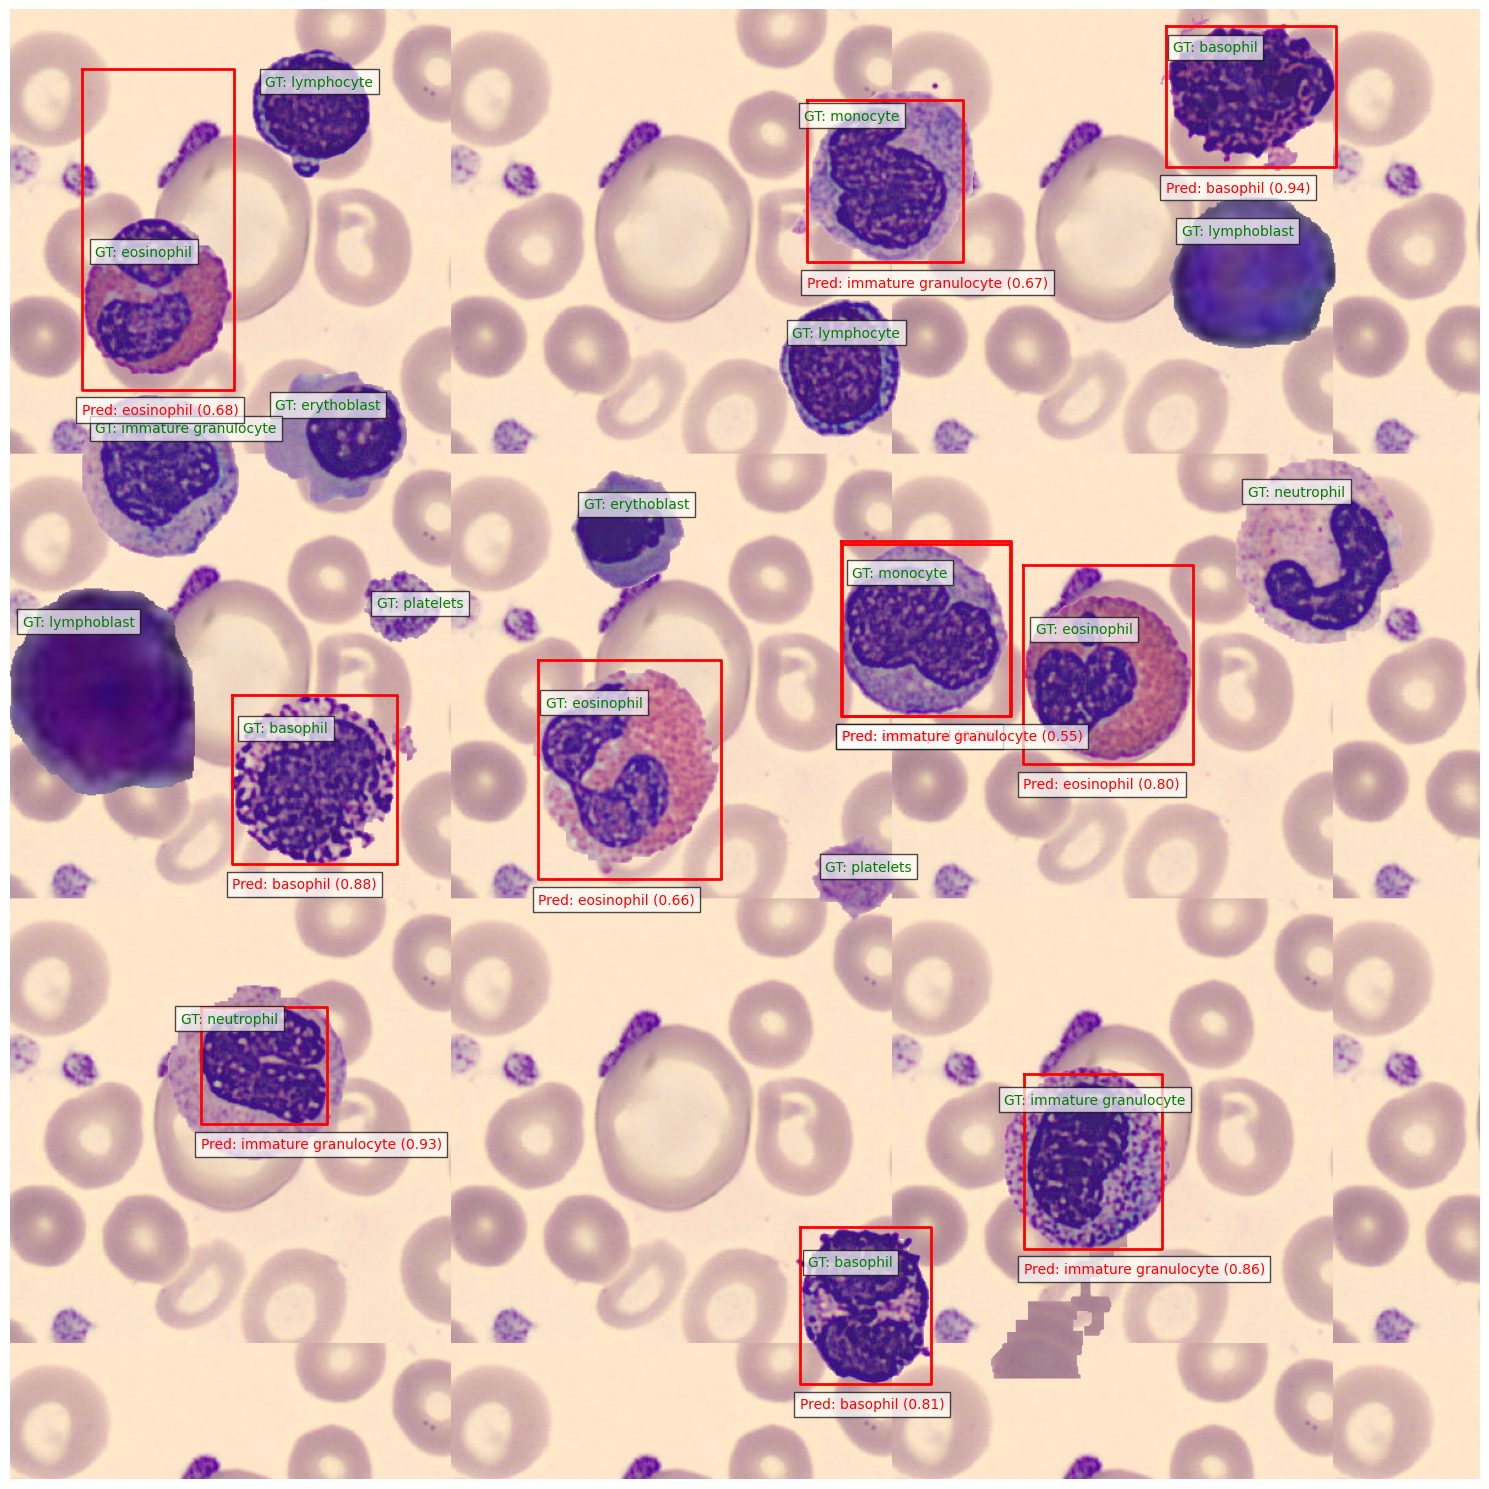

Saved visualization to output_composite_images/composite_1_vis.png
Process completed!


In [3]:
def read_label_file(label_path):
    """Read class indices from a label file"""
    if not label_path.exists():
        return []
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    class_indices = []
    for line in lines:
        parts = line.strip().split()
        if parts:
            class_indices.append(int(parts[0]))
    
    return class_indices

def place_segmented_cells_on_background(bg_image_path, segmented_dirs, label_dirs, class_names, 
                                        total_cells=45, canvas_size=(1200, 1200), max_attempts=200):
    """
    Place segmented cells (PNG with transparency) on a background image with uniform class distribution
    
    Args:
        bg_image_path: Path to background image
        segmented_dirs: Dictionary mapping class names to directories with segmented cells
        label_dirs: Dictionary mapping class names to directories with labels
        class_names: List of class names
        total_cells: Total number of cells to place in the image
        canvas_size: Size of the output canvas
        max_attempts: Maximum placement attempts per image
        
    Returns:
        tuple: (combined_image, all_labels, image_positions)
    """
    # Load the background image
    bg_image = cv2.imread(bg_image_path)
    if bg_image is None:
        raise ValueError(f"Background image could not be loaded from {bg_image_path}!")
    
    # Create a tiled background to match canvas size
    tile_size = (bg_image.shape[1], bg_image.shape[0])  # (width, height)
    rows, cols = (canvas_size[1] // tile_size[1] + 1, canvas_size[0] // tile_size[0] + 1)
    combined_img = np.tile(bg_image, (rows, cols, 1))[:canvas_size[1], :canvas_size[0]]
    
    image_positions = []
    all_labels = []
    
    # Filter out any classes with no images
    valid_classes = []
    for class_name, segmented_dir in segmented_dirs.items():
        if list(Path(segmented_dir).glob("segmented_*.png")):
            valid_classes.append(class_name)
        else:
            print(f"No segmented images found in {segmented_dir}")
    
    if not valid_classes:
        raise ValueError("No valid classes with segmented images found!")
    
    # Calculate cells per class (distribute evenly)
    num_classes = len(valid_classes)
    cells_per_class = total_cells // num_classes
    remainder = total_cells % num_classes
    
    # Create allocation dictionary
    class_allocation = {cls: cells_per_class for cls in valid_classes}
    
    # Distribute remainder cells
    for i in range(remainder):
        class_allocation[valid_classes[i]] += 1
    
    print(f"Cell allocation: {class_allocation}")
    
    # Process each cell type
    for class_name in valid_classes:
        segmented_dir = segmented_dirs[class_name]
        target_count = class_allocation[class_name]
        
        # Get all segmented images for this class
        segmented_images = list(Path(segmented_dir).glob("segmented_*.png"))
        random.shuffle(segmented_images)
        
        # Limit number of cells per class
        cell_count = 0
        
        for img_path in segmented_images:
            if cell_count >= target_count:
                break
                
            # Get original image name (removing "segmented_" prefix)
            original_name = img_path.stem.replace("segmented_", "")
            
            # Find corresponding label file
            label_path = Path(label_dirs[class_name]) / f"{original_name}.txt"
            if not label_path.exists():
                # If no label file found, use class index based on class_name
                if class_name in class_names:
                    class_indices = [class_names.index(class_name)]
                else:
                    print(f"Warning: Class {class_name} not in class_names list, skipping image")
                    continue
            else:
                class_indices = read_label_file(label_path)
                
            # Load the image with alpha channel (BGRA)
            segmented_img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
            if segmented_img is None or segmented_img.shape[2] != 4:  # Must have alpha channel
                print(f"Warning: Image {img_path} could not be loaded or doesn't have transparency")
                continue
            
            # No scaling - use original size
            orig_width, orig_height = segmented_img.shape[1], segmented_img.shape[0]
            new_width, new_height = orig_width, orig_height
                
            # No rotation
            resized_img = segmented_img
                
            # Try placing the image
            placed = False
            for attempt in range(max_attempts):
                x = random.randint(0, canvas_size[0] - new_width)
                y = random.randint(0, canvas_size[1] - new_height)
                
                # Check for collisions with previously placed images
                collision = False
                for (px, py, pw, ph) in image_positions:
                    # Add padding to ensure no overlap
                    padding = 5
                    if (x < px + pw + padding and x + new_width + padding > px and 
                        y < py + ph + padding and y + new_height + padding > py):
                        collision = True
                        break
                
                if not collision:
                    # Place the segmented image on the background
                    # For each pixel, blend based on alpha
                    alpha = resized_img[:, :, 3] / 255.0
                    alpha = np.expand_dims(alpha, axis=2)
                    
                    # Extract the region from background
                    bg_region = combined_img[y:y+new_height, x:x+new_width]
                    
                    # Ensure shapes match for blending
                    if bg_region.shape[:2] != resized_img[:, :, :3].shape[:2]:
                        continue
                        
                    # Blend cell with background using alpha
                    blended = (1.0 - alpha) * bg_region + alpha * resized_img[:, :, :3]
                    combined_img[y:y+new_height, x:x+new_width] = blended
                    
                    # Record placement
                    labels = [class_names[idx] for idx in class_indices]
                    all_labels.append(labels)
                    image_positions.append((x, y, new_width, new_height))
                    placed = True
                    cell_count += 1
                    break
            
            if not placed:
                print(f"Could not place {class_name} cell after {max_attempts} attempts")
    
    # Report final counts
    class_counts = {}
    for labels in all_labels:
        for label in labels:
            if label not in class_counts:
                class_counts[label] = 0
            class_counts[label] += 1
    
    print(f"Final cell counts: {class_counts}")
    print(f"Total cells placed: {len(all_labels)}")
    
    return combined_img, all_labels, image_positions

def create_and_display_composite_images(bg_image_path, selected_segmented_dirs, selected_label_dirs, model, 
                                       num_images=5, total_cells_per_image=20, canvas_size=(1200, 1200)):
    """
    Create multiple composite images with test segmented cells and display them in the notebook
    
    Args:
        bg_image_path: Path to background image
        selected_segmented_dirs: Dictionary mapping class names to selected segmented directories
        selected_label_dirs: Dictionary mapping class names to selected label directories
        model: YOLO model for prediction
        num_images: Number of composite images to create
        total_cells_per_image: Total number of cells per composite image
        canvas_size: Size of the output canvas
    """
    from IPython.display import display
    
    output_dir = Path("output_composite_images")
    output_dir.mkdir(exist_ok=True)
    
    for i in range(num_images):
        print(f"\nCreating composite image {i+1}/{num_images}")
        combined_img, all_labels, image_positions = place_segmented_cells_on_background(
            bg_image_path,
            selected_segmented_dirs,
            selected_label_dirs,
            model.names,
            total_cells=total_cells_per_image,
            canvas_size=canvas_size
        )
        
        # Run prediction on the combined image
        results = model(combined_img)
        
        # Save original image
        output_path = output_dir / f"composite_{i+1}.png"
        cv2.imwrite(str(output_path), combined_img)
        print(f"Saved composite image to {output_path}")
        
        # Create visualization with predictions
        fig = plt.figure(figsize=(15, 15))
        plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
        
        # Add ground truth labels
        for labels, (x, y, width, height) in zip(all_labels, image_positions):
            gt_text = "GT: " + ', '.join(set(labels))
            plt.text(x + 10, y + 30, gt_text,
                    bbox=dict(facecolor='white', alpha=0.7),
                    fontsize=10,
                    color='green')
        
        # Add predictions and boxes
        for result in results:
            boxes = result.boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf.cpu().numpy()[0]
                cls = box.cls.cpu().numpy()[0]
                
                plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'r-', linewidth=2)
                pred_text = f'Pred: {model.names[int(cls)]} ({conf:.2f})'
                plt.text(x1, y2 + 20, pred_text,
                        bbox=dict(facecolor='white', alpha=0.7),
                        fontsize=10,
                        color='red')
        
        plt.axis('off')
        plt.tight_layout()
        
        # Display in notebook
        display(fig)
        
        # Save visualization
        vis_path = output_dir / f"composite_{i+1}_vis.png"
        plt.savefig(vis_path)
        plt.close(fig)
        print(f"Saved visualization to {vis_path}")

# Create and display composite images in the notebook
create_and_display_composite_images(
    bg_image_path,
    selected_segmented_dirs,
    selected_label_dirs,
    model,
    num_images=1,  # Create 5 composite images
    total_cells_per_image=20,  # 20 cells per image
    canvas_size=(1200, 1200)  # Canvas size
)

print("Process completed!")